<a href="https://colab.research.google.com/github/SERVIR/flood_mapping_intercomparison/blob/main/notebooks/Module_6_Accuracy_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

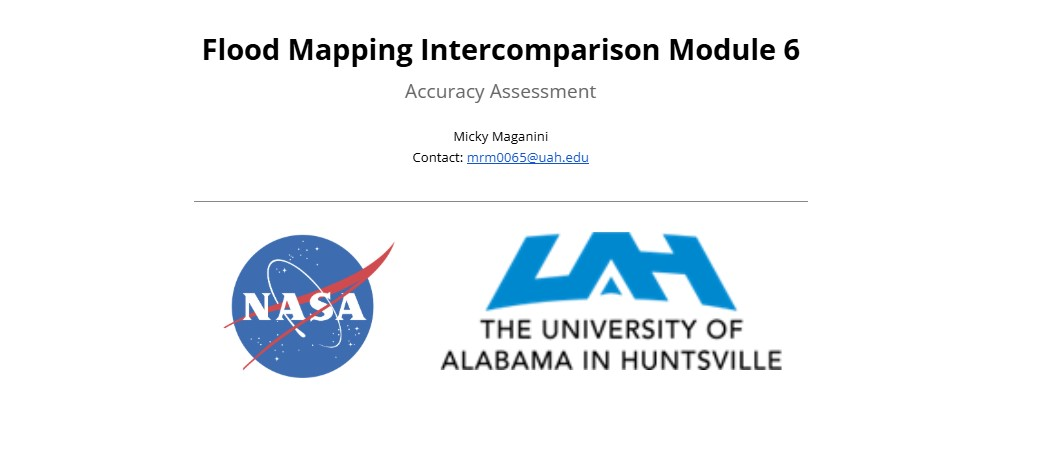

In this module, we will import all of our flood maps and conduct an accuracy assessment. We will create confusion matrices which will show True Positives (TP), False Positives(FP), False Negatives(FN), and True Negatives (TN).

* TP = True Positive. Water in reference data, water in flood map.
* FP = False Positive. Nonwater in reference data, water in flood map.
* FN = False Negative. Water in Reference Data, nonwater in flood map.
* TN = True Negative. Nonwater in reference data, nonwater in flood map.

From the confusion matrix, we can calculate the following statistics (formulas and interpretation from Landwehr et al 2024 -- See References):

* Overall Accuracy = $\begin{equation} \frac{TP + TN}{TP + FP + FN + TN} \end{equation} $
  * Proportion of correctly classified instances (regardsless of class) to the total number of instances
* Recall (aka Completeness, Sensitivity, or Producer's Accuracy for Water) = $\begin{equation} \frac{TP}{TP+FN} \end{equation} $
  * Fraction of actual positive instances that are correctly predicted
* Precision (aka Correctness aka Positive Predict Value aka User's Accuracy for Water) = $\begin{equation} \frac{TP}{TP + FP} \end{equation} $
  * Fraction of positive predictions that are actually correct.
* Specificity = Producer's Accuracy for Nonwater = $\begin{equation} \frac{TN}{TN+FP} \end{equation} $
* Negative Predictive Value = User's Accuracy for Nonwater = $\begin{equation} \frac{TN}{TN+FN} \end{equation} $
* F1 score (aka Dice Coefficient) =  $\begin{equation} \frac{2 * TP}{2 * TP + FP + FN} \end{equation} $
  * combines precision and recall to a harmonic mean
* Normalized Matthews Correlation Coefficient (aka Phi coefficient, mean square coefficiency coefficient) = $\begin{equation} \frac{\frac{TP * TN - FP * FN}{\sqrt{(TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)}}}{2} \end{equation} $
  * Correlation between observed and predicted classes. Useful for cases where there is a large class imbalance.

We will calculate the confusion matrices and above metrics for all points, for high confidence reference points, and for various slope, elevation, and landcover classes.

We will then write the results of the accuracy assessmnent to a CSV.

# Step 1: Import packages

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import ee
import geemap
import matplotlib.pyplot as plt
import sklearn.metrics
from google.colab import drive
import os
import csv
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# MODIFIABLE VARIABLE ALERT

In [ ]:
# Enter in the Google Earth Engine Folder in which your flood maps and reference data are located. Make sure the string ends in a slash
my_gee_folder = "users/mickymags/semi_fmi_arkansas_20250409/"

# Enter in the Google Earth Engine Project you will use
my_gee_project = 'servir-sco-assets'

# Enter in the Google Drive Folder you wish to use. Make sure this ends in a slash, This should start with "drive/MyDrive/..."
my_gdrive_folder = "drive/MyDrive/Flood_Intercomparison/Case_Studies/semi/semi_arkansas_20250409/"

# Enter in the date of interest in YYYY-MM-dd format
doi = "2025-04-09"

# Enter in a description of the event. This can be whatever you want it to be.
event_desc = 'Arkansas'

# Enter in a name for the output file that we will write the statistics to. Make sure this string ends in .csv
filename = 'testing_0929_module_6_stats.csv'

In [ ]:
ee.Authenticate()

ee.Initialize(project=my_gee_project)

In [ ]:
# Define the path to the area of interest and extract the latitude and longitude for mapping purposes.
aoi = ee.FeatureCollection(my_gee_folder + "aoi")
roi = aoi.geometry()
aoi_centroid = aoi.geometry().centroid()             # Get the center of the AOI
lon = aoi_centroid.coordinates().get(0).getInfo()    # Extract the longitude from the centroid
lat = aoi_centroid.coordinates().get(1).getInfo()    # Extract the latitude from the centroid

# Step 2: Import Flood Maps

Import each of the flood maps we exported at the end of Module 6, and the reference data we collected in Collect Earth Online.  

In [ ]:
# Define the paths to the flood maps and reference data
my_ref_data = ee.FeatureCollection(my_gee_folder + "reference_data")
dswx_hls = ee.Image(my_gee_folder + "dswxhls_harmonized")
dswx_s1 = ee.Image(my_gee_folder + "dswxs1_harmonized")
mcdwd = ee.Image(my_gee_folder + "mcdwd_harmonized")
hf = ee.Image(my_gee_folder + "hydrafloods_harmonized")
hydrosar = ee.Image(my_gee_folder + "hydrosar_harmonized")
gfm = ee.Image(my_gee_folder + "gfm_harmonized")
vfm = ee.Image(my_gee_folder + "vfm_harmonized")

In [ ]:
# Get the projection and scale from one of the products
my_projection = hf.projection()
my_proj_string = my_projection.getInfo()['crs']
my_scale = my_projection.nominalScale().getInfo()

In [ ]:
# Define visualization parameters for the flood maps
water_viz = {
    "min": 0,
    "max": 2,
    "palette": ['D3D3D3', '000080', 'FFFFFF']
}

In [ ]:
# Define the mask of each flood map
gfm_mask = gfm.neq(2)
mcdwd_mask = mcdwd.neq(2)
vfm_mask = vfm.neq(2)
dswxhls_mask = dswx_hls.neq(2)
dswxs1_mask = dswx_s1.neq(2)
hf_mask = hf.neq(2)
hydrosar_mask = hydrosar.neq(2)

In [ ]:
# Update all of the masks for each of the flood maps
gfm_final = gfm.updateMask(gfm_mask)
vfm_final = vfm.updateMask(vfm_mask)
mcdwd_final = mcdwd.updateMask(mcdwd_mask)
dswxhls_final = dswx_hls.updateMask(dswxhls_mask)
dswxs1_final = dswx_s1.updateMask(dswxs1_mask)
hydrosar_final = hydrosar.updateMask(hydrosar_mask)
hf_final = hf.updateMask(hf_mask)

In [ ]:
# Visualize all of the flood maps
Map = geemap.Map(center = (lat, lon), zoom = 7)
Map.addLayer(gfm_final, water_viz, 'GFM')
Map.addLayer(vfm_final, water_viz, 'VFM')
Map.addLayer(dswxhls_final, water_viz, 'DSWx-HLS')
Map.addLayer(dswxs1_final, water_viz, 'DSWx-S1')
Map.addLayer(mcdwd_final, water_viz, 'MCDWD')
Map.addLayer(hf_final, water_viz, 'HYDRAFloods')
Map.addLayer(hydrosar_final, water_viz, 'HydroSAR')
Map.addLayer(my_ref_data, {}, 'Reference Data')
Map.addLayerControl()
Map

Now let's bring in our reference data and flood maps.

Filter our reference data to two different feature collections, one that has points that were identified as water, and one that has points that were identified as nonwater.

In [ ]:
# Ge the number of reference data points
my_ref_data.size().getInfo()

In [ ]:
# Filter the reference data within the area of interest
my_ref_data = my_ref_data.filterBounds(aoi)

In [ ]:
# Get the number of reference points within the area of interest
my_ref_data.size().getInfo()

In [ ]:
# Define a function that will parse through the reference data and transform the
# water/nonwater data into a single feature with a value of 1 indicating the point
# has water, and 0 having nonwater.

def property_setter(feature_collection):
  fc_size = feature_collection.size().getInfo()

  feats = []
  for q in range(fc_size):
    feat_of_int = ee.Feature(feature_collection.toList(fc_size).get(q))
    property_of_int = feat_of_int.get('water?:yes')
    if q % 100 == 0:
      print(q)
    #print(property_of_int.getInfo())
    if property_of_int.getInfo() == 100:
      feat_of_int = feat_of_int.set('reference_water', 1)
      feats.append(feat_of_int)
    else:
      feat_of_int = feat_of_int.set('reference_water', 0)
      feats.append(feat_of_int)

  new_fc = ee.FeatureCollection(feats)
  return new_fc

In [ ]:
# Get the reference data points that are not cloudy
noncloud_points = my_ref_data.filter(ee.Filter.neq("water?:cloud", 100))

# Run the property setter function on the above reference data
# This will take a couple of minutes to run.
noncloud_points_v2 = property_setter(noncloud_points)

In [ ]:
# Filter to only points with a confidence of 74% or higher
highconf_points = noncloud_points_v2.filter(ee.Filter.gt("confidence", 74))

In [ ]:
#Water visualization Parameters
water_vp = {'min': 0,
          'max': 2,
          'palette': ['000000', '0000FF', 'FFFFFF']
}

In [ ]:
# Planet Visualization Parameters
plv = {
    'bands': ['b3', 'b2', 'b1'],
    'min': 0,
    'max': 2400,
    'gamma': 0.75
}

In [ ]:
# Rename each of the flood maps' bands to be the flood map followed by "water"
hydrafloods_renamed = hf.rename('hydrafloods_water')
hydrosar_renamed = hydrosar.rename('hydrosar_water')
gfm_renamed = gfm.rename('gfm_water')
dswxhls_renamed = dswx_hls.rename('dswxhls_water')
dswxs1_renamed = dswx_s1.rename('dswxs1_water')
mcdwd_renamed = mcdwd.rename('mcdwd_water')
vfm_renamed = vfm.rename('vfm_water')

In [ ]:
# Get high confidence points only
hf_sampled_highconf = hydrafloods_renamed.sampleRegions(highconf_points, geometries=True)
hs_sampled_highconf = hydrosar_renamed.sampleRegions(highconf_points, geometries=True)
gfm_sampled_highconf = gfm_renamed.sampleRegions(highconf_points, geometries=True)
dswxhls_sampled_highconf = dswxhls_renamed.sampleRegions(highconf_points, geometries=True)
dswxs1_sampled_highconf = dswxs1_renamed.sampleRegions(highconf_points, geometries=True)
mcdwd_sampled_highconf = mcdwd_renamed.sampleRegions(highconf_points, geometries=True)
vfm_sampled_highconf = vfm_renamed.sampleRegions(highconf_points, geometries=True)

We want to write a function that takes a featurecollection as input, and calculates the confusion matrix, prints the overall accuracy and consumer accuracy for each class. The function will take as an optional parameter a property to filter for. This will allow us to examine statistics for different land cover and/or slope classes more easily.

In [ ]:
def confusion_matrix_reporter(fc, map_label, description, product_description, slope_description, lc_description, elevation_description, region_description, stat_description, filter_prop = None, filter_value = None):

  # Create two empty arrays
  references_list = []
  classifications_list = []

  # Define the classes
  classes = np.array([1, 0])
  my_display_labels = np.array(['water', 'nonwater'])
  classes_v2 = ['water', 'nonwater']

  # if the filter property is defined...
  if filter_prop != None:

    # add an additional filter
    fc_new = fc.filter(ee.Filter.eq(filter_prop, filter_value))
    #print('path1')
  else:
    # if path 2 is followed, something unexpected is happening. You can uncomment the line below for debugging. If path2 is followed, Check your parameters and try again
    fc_new = fc
    #print('path2')

  # Get the size of the feature collection
  fc_size = fc_new.size().getInfo()
  my_feat_listed = fc_new.toList(fc_size).getInfo()

  # For reference data points within this feature collection...
  for r in range(fc_size):
    my_feat = my_feat_listed[r]['properties']                 # Get the reference data point of interest
    reference = my_feat['reference_water']                    # Determine whether the reference point was classified as water or not water in the reference data
    classification = my_feat[map_label]                       # Determine whether the reference point was classified as water or not water by the map we are evaluating
    test1 = classification == 0 or classification == 1        # ensure that values are either 0 or 1 to exclude masked values that made it through the initial mask test
    test2 = reference == 0 or reference == 1
    if test1 and test2:
      classifications_list.append(classification)
      references_list.append(reference)
  # Transform references and classifications list to arrays
  references_array = np.array(references_list)
  classifications_array = np.array(classifications_list)

  # Calculate accuracy, precision, recall, f1, score, and create confusion matrices for the references and classifications
  accuracy = sklearn.metrics.accuracy_score(references_array, classifications_array)
  acc_string = "{0} accuracy: {1:0.3f}".format(description, accuracy)

  f1 = sklearn.metrics.f1_score(references_array, classifications_array)
  f1_string = "{0} f1 score: {1:0.3f}".format(description, f1)

  prec = sklearn.metrics.precision_score(references_array, classifications_array)
  prec_string = "{0} Precision (aka user's accuracy for water): {1:0.3f}".format(description, prec)

  reca = sklearn.metrics.recall_score(references_array, classifications_array)
  reca_string = "{0} Recall (aka producer's accuracy for water): {1:0.3f}".format(description, reca)

  my_cm = sklearn.metrics.confusion_matrix(references_array, classifications_array, labels = classes)

  # Calculate true and false positives and negatives to calculate statistics not within the sklearn package
  tp = my_cm[0][0]
  fn = my_cm[0][1]
  fp = my_cm[1][0]
  tn = my_cm[1][1]

  sample_size = tp + fp + fn + tn

  specificity = tn / (tn + fp)
  spec_string = "{0} Specificity (aka producer's accuracy for nonwater): {1:0.3f}".format(description, specificity)

  npv = tn / (tn + fn)
  npv_string = "{0} Negative Predictive Value (aka nonwater user's accuracy): {1: 0.3f}".format(description, npv)

  mcc = sklearn.metrics.matthews_corrcoef(references_array, classifications_array)
  nmcc = (mcc + 1) / 2
  nmcc_string = "{0} Normalized Matthew's Correlation Coefficien: {1:0.3f}".format(description, nmcc)

  # print results to the console
  if stat_description == 'Overall Accuracy' or stat_description == 'Recall' or stat_description == 'Precision' or stat_description == 'Specificity' or stat_description == 'NPV' or stat_description == 'F1 Score' or stat_description == 'NMCC':
    x = 0
  else:
    print("Invalid Stat Description. Please input one of Overall Accuracy, Recall, Precision, Specificity, NPV, F1 Score, or NMCC")
  if stat_description == 'Overall Accuracy':
    my_stat = accuracy
  if stat_description == 'Recall':
    my_stat = reca
  if stat_description == 'Precision':
    my_stat = prec
  if stat_description == 'Specificity':
    my_stat = specificity
  if stat_description == 'NPV':
    my_stat = npv
  if stat_description == 'F1 Score':
    my_stat = f1
  if stat_description == 'NMCC':
    my_stat = nmcc

  # Define an output_list that will be retained by this function call. This will eventually be written to a CSV with the description and the statistic calculated
  output_list = [region_description, product_description, stat_description, lc_description, elevation_description, slope_description, my_stat]
  print(output_list)

  return output_list

# Step 3: All Land Cover Types, All Slopes, All Elevations

Now we will run the confusion_matrix_reporter function on all of our flood maps using our reference data. We will have to run this function each time we want to generate a certain metric (e.g. accuracy, precision, recall, F1 score, NMCC). In this section, we will calculate these metrics for the entire set of reference data within the area of interest. We will also do this for different subsets of the data (i.e. for different land cover types, slope regimes, and elevation regimes).

## Step 3 Part 1: HYDRAfloods

In [ ]:
#accuracy_reporter(hf_sampled_highconf, 'reference_water', 'hydrafloods_water', 'HYDRAFloods High Confidence')
hydrafloods_all_acc = confusion_matrix_reporter(hf_sampled_highconf, 'hydrafloods_water', 'HYDRAFloods High Confidence', product_description='HYDRAFloods', slope_description='All',
                                                 lc_description = 'All', elevation_description='All', region_description=event_desc,stat_description='Overall Accuracy')

In [ ]:
hydrafloods_all_prec = confusion_matrix_reporter(hf_sampled_highconf, 'hydrafloods_water', 'HYDRAFloods High Confidence', product_description='HYDRAFloods', slope_description='All',
                                                 lc_description = 'All', elevation_description='All', region_description=event_desc,stat_description='Precision')

In [ ]:
hydrafloods_all_rec = confusion_matrix_reporter(hf_sampled_highconf, 'hydrafloods_water', 'HYDRAFloods High Confidence', product_description='HYDRAFloods', slope_description='All',
                                                 lc_description = 'All', elevation_description='All', region_description=event_desc,stat_description='Recall')

In [ ]:
hydrafloods_all_f1 = confusion_matrix_reporter(hf_sampled_highconf, 'hydrafloods_water', 'HYDRAFloods High Confidence', product_description='HYDRAFloods', slope_description='All',
                                                 lc_description = 'All', elevation_description='All', region_description=event_desc,stat_description='F1 Score')

In [ ]:
hydrafloods_all_nmcc = confusion_matrix_reporter(hf_sampled_highconf, 'hydrafloods_water', 'HYDRAFloods High Confidence', product_description='HYDRAFloods', slope_description='All',
                                                 lc_description = 'All', elevation_description='All', region_description=event_desc,stat_description='NMCC')

## Step 3 Part 2: HYDROSAR

In [ ]:
hydrosar_all_acc = confusion_matrix_reporter(hs_sampled_highconf, 'hydrosar_water', 'HYDROSAR High Confidence', product_description='HYDROSAR', slope_description='All',
                                                 lc_description = 'All', elevation_description='All', region_description=event_desc,stat_description='Overall Accuracy')

hydrosar_all_prec = confusion_matrix_reporter(hs_sampled_highconf, 'hydrosar_water', 'HYDROSAR High Confidence', product_description='HYDROSAR', slope_description='All',
                                                 lc_description = 'All', elevation_description='All', region_description=event_desc,stat_description='Precision')

hydrosar_all_rec = confusion_matrix_reporter(hs_sampled_highconf, 'hydrosar_water', 'HYDROSAR High Confidence', product_description='HYDROSAR', slope_description='All',
                                                 lc_description = 'All', elevation_description='All', region_description=event_desc,stat_description='Recall')

hydrosar_all_f1 = confusion_matrix_reporter(hs_sampled_highconf, 'hydrosar_water', 'HYDROSAR High Confidence', product_description='HYDROSAR', slope_description='All',
                                                 lc_description = 'All', elevation_description='All', region_description=event_desc,stat_description='F1 Score')

hydrosar_all_nmcc = confusion_matrix_reporter(hs_sampled_highconf, 'hydrosar_water', 'HYDROSAR High Confidence', product_description='HYDROSAR', slope_description='All',
                                                 lc_description = 'All', elevation_description='All', region_description=event_desc,stat_description='NMCC')

## Step 3 Part 3: GFM

In [ ]:
gfm_all_acc = confusion_matrix_reporter(gfm_sampled_highconf, 'gfm_water', 'gfm High Confidence', product_description='GFM', slope_description='All',
                                                 lc_description = 'All', elevation_description='All', region_description=event_desc,stat_description='Overall Accuracy')

gfm_all_prec = confusion_matrix_reporter(gfm_sampled_highconf, 'gfm_water', 'GFM High Confidence', product_description='GFM', slope_description='All',
                                         lc_description = 'All', elevation_description='All', region_description=event_desc, stat_description='Precision')

gfm_all_rec = confusion_matrix_reporter(gfm_sampled_highconf, 'gfm_water', 'GFM High Confidence', product_description='GFM', slope_description='All',lc_description='All', elevation_description='All',
                                                 region_description=event_desc,stat_description='Recall')

gfm_all_f1 = confusion_matrix_reporter(gfm_sampled_highconf, 'gfm_water', 'GFM High Confidence', product_description='GFM', slope_description='All', lc_description = 'All', elevation_description='All',
                                                 region_description=event_desc,stat_description='F1 Score')

gfm_all_nmcc = confusion_matrix_reporter(gfm_sampled_highconf, 'gfm_water', 'GFM High Confidence', product_description='GFM', slope_description='All', lc_description = 'All', elevation_description='All',
                                         region_description=event_desc,stat_description='NMCC')

## Step 3 Part 4: DSWx-HLS

In [ ]:
dswxhls_all_acc = confusion_matrix_reporter(dswxhls_sampled_highconf, 'dswxhls_water', 'DSWx-HLS High Confidence', product_description='DSWx-HLS',slope_description='All',lc_description='All',elevation_description='All',region_description=event_desc, stat_description = 'Overall Accuracy')

dswxhls_all_rec = confusion_matrix_reporter(dswxhls_sampled_highconf,'dswxhls_water', 'DSWx-HLS High Confidence', product_description='DSWx-HLS',slope_description='All',lc_description='All',elevation_description='All',region_description=event_desc, stat_description = 'Recall')

dswxhls_all_prec = confusion_matrix_reporter(dswxhls_sampled_highconf,  'dswxhls_water', 'DSWx-HLS High Confidence', product_description='DSWx-HLS',slope_description='All',lc_description='All',elevation_description='All',region_description=event_desc, stat_description = 'Precision')

dswxhls_all_f1 = confusion_matrix_reporter(dswxhls_sampled_highconf,'dswxhls_water', 'DSWx-HLS High Confidence', product_description='DSWx-HLS', slope_description='All',lc_description='All',elevation_description='All',region_description=event_desc, stat_description = 'F1 Score')

dswxhls_all_nmcc = confusion_matrix_reporter(dswxhls_sampled_highconf,'dswxhls_water', 'DSWx-HLS High Confidence',product_description='DSWx-HLS',slope_description='All',lc_description='All',elevation_description='All',region_description=event_desc, stat_description = 'NMCC')

## Step 3 Part 5: DSWx-S1

In [ ]:
dswxs1_all_acc = confusion_matrix_reporter(dswxs1_sampled_highconf, 'dswxs1_water', 'DSWx-S1 High Confidence', product_description='DSWx-S1',slope_description='All',lc_description='All',elevation_description='All',region_description=event_desc, stat_description = 'Overall Accuracy')

dswxs1_all_rec = confusion_matrix_reporter(dswxs1_sampled_highconf,'dswxs1_water', 'DSWx-S1 High Confidence', product_description='DSWx-S1',slope_description='All',lc_description='All',elevation_description='All',region_description=event_desc, stat_description = 'Recall')

dswxs1_all_prec = confusion_matrix_reporter(dswxs1_sampled_highconf,  'dswxs1_water', 'DSWx-S1 High Confidence', product_description='DSWx-S1',slope_description='All',lc_description='All',elevation_description='All',region_description=event_desc, stat_description = 'Precision')

dswxs1_all_f1 = confusion_matrix_reporter(dswxs1_sampled_highconf,'dswxs1_water', 'DSWx-S1 High Confidence', product_description='DSWx-S1', slope_description='All',lc_description='All',elevation_description='All',
                                                 region_description=event_desc,stat_description='F1 Score')

dswxs1_all_nmcc = confusion_matrix_reporter(dswxs1_sampled_highconf,'dswxs1_water', 'DSWx-S1 High Confidence', product_description='DSWx-S1',slope_description='All',
                                         lc_description = 'All', elevation_description='All', region_description=event_desc,stat_description='NMCC')

## Step 3 Part 6: MCDWD

In [ ]:
mcdwd_all_acc = confusion_matrix_reporter(mcdwd_sampled_highconf, 'mcdwd_water', 'MCDWD High Confidence', product_description='MCDWD',slope_description='All',\
                                          lc_description='All',elevation_description='All',region_description=event_desc, stat_description = 'Overall Accuracy')

mcdwd_all_rec = confusion_matrix_reporter(mcdwd_sampled_highconf,'mcdwd_water', 'MCDWD High Confidence', product_description='MCDWD',slope_description='All',\
                                          lc_description='All',elevation_description='All',region_description=event_desc, stat_description = 'Recall')

mcdwd_all_prec = confusion_matrix_reporter(mcdwd_sampled_highconf,  'mcdwd_water', 'MCDWD High Confidence', product_description='MCDWD',slope_description='All',\
                                          lc_description='All',elevation_description='All',region_description=event_desc, stat_description = 'Precision')

mcdwd_all_f1 = confusion_matrix_reporter(mcdwd_sampled_highconf,'mcdwd_water', 'MCDWD High Confidence', product_description='MCDWD', slope_description='All',\
                                          lc_description='All',elevation_description='All',region_description=event_desc, stat_description = 'F1 Score')

mcdwd_all_nmcc = confusion_matrix_reporter(mcdwd_sampled_highconf,'mcdwd_water', 'MCDWD High Confidence', product_description='MCDWD',slope_description='All',\
                                          lc_description='All',elevation_description='All',region_description=event_desc, stat_description = 'NMCC')

## Step 3 Part 7: VFM

In [ ]:
vfm_all_acc = confusion_matrix_reporter(vfm_sampled_highconf, 'vfm_water', 'VFM High Confidence', product_description='VFM',slope_description='All',\
                                          lc_description='All',elevation_description='All',region_description=event_desc, stat_description = 'Overall Accuracy')
vfm_all_rec = confusion_matrix_reporter(vfm_sampled_highconf,'vfm_water', 'VFM High Confidence', product_description='VFM',slope_description='All',\
                                          lc_description='All',elevation_description='All',region_description=event_desc, stat_description = 'Recall')
vfm_all_prec = confusion_matrix_reporter(vfm_sampled_highconf,  'vfm_water', 'VFM High Confidence', product_description='VFM',slope_description='All',\
                                         lc_description='All',elevation_description='All',region_description=event_desc, stat_description = 'Precision')
vfm_all_f1 = confusion_matrix_reporter(vfm_sampled_highconf,'vfm_water', 'VFM High Confidence', product_description='VFM', slope_description='All',\
                                          lc_description='All',elevation_description='All',region_description=event_desc, stat_description = 'F1 Score')
vfm_all_nmcc= confusion_matrix_reporter(vfm_sampled_highconf,'vfm_water', 'VFM High Confidence', product_description='VFM',slope_description='All',\
                                          lc_description='All',elevation_description='All',region_description=event_desc,stat_description='NMCC')

# Step 4: Elevation

We want to go through the entire reference dataset, and add a column for its elevation class as well as its slope class. The elevation data used will be the Copernicus GLO30 DEM, and we will determine the slope based on the `ee.Algorithms.Terrain` method offered by Google Earth Engine.

The slopes and elevations were split into four classes each based on a statistical analysis of slopes and elevations across SERVIR regions. The code for this analysis uses open data and can be found [here](https://colab.research.google.com/drive/1TW1u7O6ha2A2puuZ0JcI5MZaLZzD7Zm0?usp=sharing)

In [ ]:
# Get the Copernicus DEM from Google Earth Engine
copernicus = ee.ImageCollection("COPERNICUS/DEM/GLO30")

# Get the Shuttle Radar Topography Mission (SRTM) DEM from Google Earth Engine
srtm = ee.Image("USGS/SRTMGL1_003")

# Clip the Shuttle Radar Topography Mission data to the Area of Interest
srtm_clip = srtm.clip(aoi)

# Get the projection of the Shuttle Radar Topography Mission Data
srtm_projection = srtm_clip.projection()

In [ ]:
# Create a Copernicus DEM mosaic by filtering and clipping to the area of interest
cop_mos = copernicus.filterBounds(aoi).mosaic().clip(aoi)

# Select the DEM band, rename it to elevation, and reproject to the SRTM projection
cop_mos = cop_mos.select(['DEM']).rename(['elevation']).reproject(srtm_projection)

We will have four different elevation classes, which were empirically determined to break up a subset of global elevation data into roughly equal groups. This was done in the "Section_C" script found in this project's [Github](https://github.com/SERVIR/flood_mapping_intercomparison/tree/main/notebooks). The elevation classes are as follows:

*   Elevation Class 1:  Elevation < 140 meters
*   Elevation Class 2: 140 meters < Elevation < 300 meters
*   Elevation Class 3: 300 meters < Elevation < 496 meters
*   Elevation Class 4: Elevation > 496 meters




In [ ]:
# Define the logic for each elevation class as shown above
elc1 = cop_mos.select('elevation').lt(140)                            # Elevation Class 1
elc2 = cop_mos.select('elevation').gte(140).And(cop_mos.lt(300))      # Elevation Class 2
elc3 = cop_mos.select('elevation').gte(300).And(cop_mos.lt(496))      # Elevation Class 3
elc4 = cop_mos.select('elevation').gte(496)                           # Elevation Class 4

In [ ]:
# Define visualization parameters for our elevation class image
vp2 = {
    'band': ['elevation'], #'band': ['DEM'],
    'min': 0,
    'max':4
}

Now, let's construct an image based off of our DEM that has a value of 1 for pixels within elevation class 1, a value of 2 for pixels within elevation class 2, etc.

In [ ]:
el1test = elc1.select('elevation').eq(1)
el2test = elc2.select('elevation').eq(1)
el3test = elc3.select('elevation').eq(1)
el4test = elc4.select('elevation').eq(1)

el_v1 = hf.where(el1test, ee.Image(1))
el_v2 = el_v1.where(el2test, ee.Image(2))
el_v3 = el_v2.where(el3test, ee.Image(3))
el_v4 = el_v3.where(el4test, ee.Image(4))

In [ ]:
el_class_image = el_v4.rename("elevation_class")

Now we have created a raster that has a value of 1 where there is low elevation (< 140 meters), a value of 2 where there is moderately low elevation (140 < x < 300 meters), a value of 3 where there is moderately high elevation (300 < x < 496 meters), and a value of 4 where there is very high elevation ( > 496 meters).

Now, let's use the .sampleRegions() region to add the elevation information to the map.

In [ ]:
#vfm_highconf_points = confusion_matrix_reporter(vfm_sampled_highconf, 'vfm_water', 'VFM High Confidence')

In [ ]:
#HYDRAFloods sampled with elevation
hf_swel = el_class_image.sampleRegions(hf_sampled_highconf, geometries=True, projection = my_proj_string, scale = my_scale)

dswxhls_swel = el_class_image.sampleRegions(dswxhls_sampled_highconf, geometries=True, projection = my_proj_string, scale = my_scale)

dswxs1_swel = el_class_image.sampleRegions(dswxs1_sampled_highconf, geometries=True, projection = my_proj_string, scale = my_scale)

gfm_swel = el_class_image.sampleRegions(gfm_sampled_highconf, geometries=True, projection = my_proj_string, scale = my_scale)

hydrosar_swel = el_class_image.sampleRegions(hs_sampled_highconf, geometries=True, projection = my_proj_string, scale = my_scale)

mcdwd_swel = el_class_image.sampleRegions(mcdwd_sampled_highconf, geometries=True, projection = my_proj_string, scale = my_scale)

vfm_swel = el_class_image.sampleRegions(vfm_sampled_highconf, geometries=True, projection = my_proj_string, scale = my_scale)

Now we want to find out how many elevation classes are present in our reference data

In [ ]:
feat_listed = hf_swel.toList(hf_swel.size().getInfo()).getInfo()

In [ ]:
el_classes_present = []
very_low_n = 0
moderately_low_n = 0
moderately_high_n = 0
very_high_n = 0

for j in range(len(feat_listed)):
  feat_mine = feat_listed[j]['properties']
  el_class = feat_mine['elevation_class']
  #print(feat_mine.keys())
  #break
  el_class = feat_mine['elevation_class']
  if el_class not in el_classes_present and el_class != None and el_class != 0:
    el_classes_present.append(el_class)
  if el_class == 1:
    very_low_n += 1
  if el_class == 2:
    moderately_low_n += 1
  if el_class == 3:
    moderately_high_n += 1
  if el_class == 4:
    very_high_n += 1

In [ ]:
print("There is/are {0} elevation class(es) present in the sample points".format(len(el_classes_present)))
print("The elevation class(es) present are: ",el_classes_present)
print("There are {0} very low elevation points".format(very_low_n))
print("There are {0} moderately low elevation points".format(moderately_low_n))
print("There are {0} moderately high elevation points".format(moderately_high_n))
print("There are {0} very high elevation points".format(very_high_n))

**IMPORTANT: Based on the above statistics, delete Parts 2 through 5 depending on which elevation classes are represented in the reference data.**

In [ ]:
# Visualize the Elevation Classes on the map.
Map = geemap.Map(center = (lat, lon), zoom = 6)
Map.addLayer(el_class_image.clip(aoi), vp2, 'el_class')
Map.addLayer(aoi, {}, 'Area of interest')

Map

In [ ]:
# HYDRAFloods Sampled With Elevation
#hf_swel = el_class_image.sampleRegions(hf_sampled_highconf, geometries=True, projection = my_proj_string, scale = my_scale)

## Step 4 Part 2: Very Low Elevation

Just as we did in Part 3, we will run the confusion_matrix_reporter function on every flood map, except this time we will generate statistics over subsets of the data, specifically different elevation classes. Let's start by calculating the statistics over just reference data points that fall within Elevation Class 1.

### Step 4 Part 2 Section A: HYDRAFLoods Very Low Elevation

In [ ]:
# HYDRAFloods Very Low Elevation Accuracy
hydrafloods_vlowel_acc = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 1)

hydrafloods_vlowel_rec = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 1)

hydrafloods_vlowel_prec = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description = 'Precision', filter_prop = 'elevation_class', filter_value = 1)

hydrafloods_vlowel_f1 = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description = 'F1 Score', filter_prop = 'elevation_class', filter_value = 1)

hydrafloods_vlowel_nmcc = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description = 'NMCC', filter_prop = 'elevation_class', filter_value = 1)

### Step 4 Part 2 Section B: HYDROSAR Very Low Elevation

In [ ]:
# HYDROSAR Very Low Elevation Accuracy
hydrosar_vlowel_acc = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 1)

hydrosar_vlowel_prec = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 1)

hydrosar_vlowel_rec = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 1)

hydrosar_vlowel_f1 = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 1)

hydrosar_vlowel_nmcc = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 1)

### Step 4 Part 2 Section C: DSWx-HLS Very Low Elevation

In [ ]:
dswxhls_vlowel_acc = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Very Low Elevation', product_description = 'DSWx-HLS',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 1)

dswxhls_vlowel_prec = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Very Low Elevation', product_description = 'DSWx-HLS',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 1)

dswxhls_vlowel_rec = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Very Low Elevation', product_description = 'DSWx-HLS',\
                                               slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                               stat_description='Recall', filter_prop = 'elevation_class', filter_value = 1)

dswxhls_vlowel_f1 = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Very Low Elevation', product_description = 'DSWx-HLS',\
                                              slope_description = 'All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                              stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 1)

dswxhls_vlowel_nmcc = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Very Low Elevation', product_description = 'DSWx-HLS',\
                                                slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                 stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 1)

### Step 4 Part 2 Section D: DSWx-S1 Very Low Elevation

In [ ]:
dswxs1_vlowel_acc = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Very Low Elevation', product_description = 'DSWx-S1',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 1)

dswxs1_vlowel_prec = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Very Low Elevation', product_description = 'DSWx-S1',\
                                               slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                               stat_description='Precision', filter_prop = 'elevation_class', filter_value = 1)

dswxs1_vlowel_rec = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Very Low Elevation', product_description = 'DSWx-S1',\
                                              slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                              stat_description='Recall', filter_prop = 'elevation_class', filter_value = 1)

dswxs1_vlowel_f1 = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Very Low Elevation', product_description = 'DSWx-S1',\
                                              slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                              stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 1)

dswxs1_vlowel_nmcc = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Very Low Elevation', product_description = 'DSWx-S1',\
                                               slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                               stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 1)

### Step 4 Part 2 Section E: GFM Very Low Elevation

In [ ]:
gfm_vlowel_acc = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 1)

gfm_vlowel_prec = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 1)

gfm_vlowel_rec = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 1)

gfm_vlowel_f1 = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 1)

gfm_vlowel_nmcc = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                            slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                            stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 1)

### Step 4 Part 2 Section F: MCDWD Very Low Elevation

In [ ]:
mcdwd_vlowel_acc = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 1)

mcdwd_vlowel_rec = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 1)

mcdwd_vlowel_prec = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description = 'All', lc_description = 'All', elevation_description = 'Very Low', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 1)

mcdwd_vlowel_f1 = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 1)

mcdwd_vlowel_nmcc = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 1)

### Step 4 Part 2 Section G: VFM Very Low Elevation

In [ ]:
vfm_vlowel_acc = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Very Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 1)

vfm_vlowel_rec = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Very Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 1)

vfm_vlowel_prec = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Very Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 1)

vfm_vlowel_f1 = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Very Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 1)

vfm_vlowel_nmcc = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Very Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Very Low', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 1)

## Step 4 Part 3: Moderately Low Elevation

Now let's calculate the metrics over reference data points that fall into elevation class 2.

### Step 4 Part 3 Section A: DSWx-HLS Moderately Low Elevation

In [ ]:
dswxhls_modlowel_acc = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Very Low Elevation', product_description = 'DSWx-HLS',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 2)

dswxhls_modlowel_prec = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Very Low Elevation', product_description = 'DSWx-HLS',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 2)

dswxhls_modlowel_rec = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Very Low Elevation', product_description = 'DSWx-HLS',\
                                               slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                               stat_description='Recall', filter_prop = 'elevation_class', filter_value = 2)

dswxhls_modlowel_f1 = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Very Low Elevation', product_description = 'DSWx-HLS',\
                                              slope_description = 'All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                              stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 2)

dswxhls_modlowel_nmcc = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Very Low Elevation', product_description = 'DSWx-HLS',\
                                                slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                 stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 2)

### Step 4 Part 3 Section B: DSWx-S1 Moderately Low Elevation

In [ ]:
dswxs1_modlowel_acc = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Very Low Elevation', product_description = 'DSWx-S1',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 2)

dswxs1_modlowel_prec = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Very Low Elevation', product_description = 'DSWx-S1',\
                                               slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                               stat_description='Precision', filter_prop = 'elevation_class', filter_value = 2)

dswxs1_modlowel_rec = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Very Low Elevation', product_description = 'DSWx-S1',\
                                              slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                              stat_description='Recall', filter_prop = 'elevation_class', filter_value = 2)

dswxs1_modlowel_f1 = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Very Low Elevation', product_description = 'DSWx-S1',\
                                              slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                              stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 2)

dswxs1_modlowel_nmcc = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Very Low Elevation', product_description = 'DSWx-S1',\
                                               slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                               stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 2)

### Step 4 Part 3 Section C: GFM Moderately Low Elevation

In [ ]:
gfm_modlowel_acc = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 2)

gfm_modlowel_prec = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately  Low', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 2)

gfm_modlowel_rec = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately  Low', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 2)

gfm_modlowel_f1 = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately  Low', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 2)

gfm_modlowel_nmcc = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                            slope_description='All',lc_description='All',elevation_description='Moderately  Low', region_description=event_desc,\
                                            stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 2)

### Step 4 Part 3 Section D: HYDRAFloods Moderately Low Elevation

In [ ]:
# HYDRAFloods Very Low Elevation Accuracy
hydrafloods_modlowel_acc = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 2)

hydrafloods_modlowel_rec = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 2)

hydrafloods_modlowel_prec = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description = 'Precision', filter_prop = 'elevation_class', filter_value = 2)

hydrafloods_modlowel_f1 = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description = 'F1 Score', filter_prop = 'elevation_class', filter_value = 2)

hydrafloods_modlowel_nmcc = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description = 'NMCC', filter_prop = 'elevation_class', filter_value = 2)

### Step 4 Part 3 Section E: HYDROSAR Moderately Low Elevation

In [ ]:
# HYDROSAR Very Low Elevation Accuracy
hydrosar_modlowel_acc = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 2)

hydrosar_modlowel_prec = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 2)

hydrosar_modlowel_rec = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 2)

hydrosar_modlowel_f1 = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 2)

hydrosar_modlowel_nmcc = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 2)

### Step 4 Part 3 Section F: MCDWD Moderately Low Elevation

In [ ]:
mcdwd_modlowel_acc = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 2)

mcdwd_modlowel_rec = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 2)

mcdwd_modlowel_prec = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 2)

mcdwd_modlowel_f1 = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 2)

mcdwd_modlowel_nmcc = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 2)

### Step 4 Part 3 Section G: VFM Moderately Low Elevation

In [ ]:
vfm_modlowel_acc = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Moderately Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 2)

vfm_modlowel_rec = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Moderately Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 2)

vfm_modlowel_prec = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Moderately Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 2)

vfm_modlowel_f1 = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Moderately Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 2)

vfm_modlowel_nmcc = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Moderately Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately Low', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 2)

## Step 4 Part 4: Moderately High Elevation

We will call points that fall into elevation class 4 "moderately high" elevation. Let's calculate statistics over this group

### Step 4 Part 4 Section A: DSWx-HLS Moderately High Elevation

In [ ]:
dswxhls_modhiel_acc = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Moderately High Elevation', product_description = 'DSWx-HLS',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 3)

dswxhls_modhiel_prec = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Moderately HighElevation', product_description = 'DSWx-HLS',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 3)

dswxhls_modhiel_rec = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Moderately High Elevation', product_description = 'DSWx-HLS',\
                                               slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                               stat_description='Recall', filter_prop = 'elevation_class', filter_value = 3)

dswxhls_modhiel_f1 = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Moderately High Elevation', product_description = 'DSWx-HLS',\
                                              slope_description = 'All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                              stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 3)

dswxhls_modhiel_nmcc = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Moderately High Elevation', product_description = 'DSWx-HLS',\
                                                slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                 stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 3)

### Step 4 Part 4 Section B: DSWx-S1 Moderately High Elevation

In [ ]:
dswxs1_modhiel_acc = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Moderately High Elevation', product_description = 'DSWx-S1',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 3)

dswxs1_modhiel_prec = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Moderately High Elevation', product_description = 'DSWx-S1',\
                                               slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                               stat_description='Precision', filter_prop = 'elevation_class', filter_value = 3)

dswxs1_modhiel_rec = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Moderately High Elevation', product_description = 'DSWx-S1',\
                                              slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                              stat_description='Recall', filter_prop = 'elevation_class', filter_value = 3)

dswxs1_modhiel_f1 = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Moderately High Elevation', product_description = 'DSWx-S1',\
                                              slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                              stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 3)

dswxs1_modhiel_nmcc = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Moderately High Elevation', product_description = 'DSWx-S1',\
                                               slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                               stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 3)

### Step 4 Part 4 Section C: GFM Moderately High Elevation

In [ ]:
gfm_modhiel_acc = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 3)

gfm_modhiel_prec = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 3)

gfm_modhiel_rec = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 3)

gfm_modhiel_f1 = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 3)

gfm_modhiel_nmcc = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                            slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                            stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 3)

### Step 4 Part 4 Section D: HYDRAFloods Moderately High Elevation

In [ ]:
# HYDRAFloods Very Low Elevation Accuracy
hydrafloods_modhiel_acc = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 3)

hydrafloods_modhiel_rec = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 3)

hydrafloods_modhiel_prec = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description = 'Precision', filter_prop = 'elevation_class', filter_value = 3)

hydrafloods_modhiel_f1 = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description = 'F1 Score', filter_prop = 'elevation_class', filter_value = 3)

hydrafloods_modhiel_nmcc = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description = 'NMCC', filter_prop = 'elevation_class', filter_value = 3)

### Step 4 Part 4 Section E: HYDROSAR Moderately High Elevation

In [ ]:
# HYDROSAR Very Low Elevation Accuracy
hydrosar_modhiel_acc = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 3)

hydrosar_modhiel_prec = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 3)

hydrosar_modhiel_rec = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 3)

hydrosar_modhiel_f1 = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 3)

hydrosar_modhiel_nmcc = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 3)

### Step 4 Part 4 Section F: MCDWD Moderately High Elevation

In [ ]:
mcdwd_modhiel_acc = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 3)

mcdwd_modhiel_rec = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 3)

mcdwd_modhiel_prec = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 3)

mcdwd_modhiel_f1 = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 3)

mcdwd_modhiel_nmcc = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 3)

### Step 4 Part 4 Section G: VFM Moderately High Elevation

In [ ]:
vfm_modhiel_acc = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Moderately Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 3)

vfm_modhiel_rec = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Moderately Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 3)

vfm_modhiel_prec = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Moderately Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 3)

vfm_modhiel_f1 = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Moderately Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 3)

vfm_modhiel_nmcc = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Moderately Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 3)

## Step 4 Part 5: Very High Elevation

Calculate the metrics for reference data points that fall within elevation class 4.

### Step 4 Part 5 Section A: DSWx-HLS Very High Elevation

In [ ]:
dswxhls_vhiel_acc = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Moderately High Elevation', product_description = 'DSWx-HLS',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 4)

dswxhls_vhiel_prec = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Moderately HighElevation', product_description = 'DSWx-HLS',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 4)

dswxhls_vhiel_rec = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Moderately High Elevation', product_description = 'DSWx-HLS',\
                                               slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                               stat_description='Recall', filter_prop = 'elevation_class', filter_value = 4)

dswxhls_vhiel_f1 = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Moderately High Elevation', product_description = 'DSWx-HLS',\
                                              slope_description = 'All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                              stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 4)

dswxhls_vhiel_nmcc = confusion_matrix_reporter(dswxhls_swel, 'dswxhls_water', 'DSWx-HLS Moderately High Elevation', product_description = 'DSWx-HLS',\
                                                slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                 stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 4)

### Step 4 Part 5 Section B: DSWx-S1 Very High Elevation

In [ ]:
dswxs1_vhiel_acc = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Moderately High Elevation', product_description = 'DSWx-S1',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 4)

dswxs1_vhiel_prec = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Moderately High Elevation', product_description = 'DSWx-S1',\
                                               slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                               stat_description='Precision', filter_prop = 'elevation_class', filter_value = 4)

dswxs1_vhiel_rec = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Moderately High Elevation', product_description = 'DSWx-S1',\
                                              slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                              stat_description='Recall', filter_prop = 'elevation_class', filter_value = 4)

dswxs1_vhiel_f1 = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Moderately High Elevation', product_description = 'DSWx-S1',\
                                              slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                              stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 4)

dswxs1_vhiel_nmcc = confusion_matrix_reporter(dswxs1_swel, 'dswxs1_water', 'DSWx-S1 Moderately High Elevation', product_description = 'DSWx-S1',\
                                               slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                               stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 4)

### Step 4 Part 5 Section C: GFM Very High Elevation

In [ ]:
gfm_vhiel_acc = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 4)

gfm_vhiel_prec = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 4)

gfm_vhiel_rec = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 4)

gfm_vhiel_f1 = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 4)

gfm_vhiel_nmcc = confusion_matrix_reporter(gfm_swel, 'gfm_water', 'GFM Very Low Elevation', product_description = 'GFM',\
                                            slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                            stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 4)

### Step 4 Part 5 Section D: HYDRAFloods Very High Elevation

In [ ]:
# HYDRAFloods Very Low Elevation Accuracy
hydrafloods_vhiel_acc = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 4)

hydrafloods_vhiel_rec = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 4)

hydrafloods_vhiel_prec = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description = 'Precision', filter_prop = 'elevation_class', filter_value = 4)

hydrafloods_vhiel_f1 = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description = 'F1 Score', filter_prop = 'elevation_class', filter_value = 4)

hydrafloods_vhiel_nmcc = confusion_matrix_reporter(hf_swel, 'hydrafloods_water', 'HYDRAFloods Very Low Elevation', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description = 'NMCC', filter_prop = 'elevation_class', filter_value = 4)

### Step 4 Part 5 Section E: HYDROSAR Very High Elevation

In [ ]:
# HYDROSAR Very Low Elevation Accuracy
hydrosar_vhiel_acc = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 4)

hydrosar_vhiel_prec = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 4)

hydrosar_vhiel_rec = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 4)

hydrosar_vhiel_f1 = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 4)

hydrosar_vhiel_nmcc = confusion_matrix_reporter(hydrosar_swel, 'hydrosar_water', 'HYDROSAR Very Low Elevation', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 4)

### Step 4 Part 5 Section F: MCDWD Very High Elevation

In [ ]:
mcdwd_vhiel_acc = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 4)

mcdwd_vhiel_rec = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 4)

mcdwd_vhiel_prec = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 4)

mcdwd_vhiel_f1 = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 4)

mcdwd_vhiel_nmcc = confusion_matrix_reporter(mcdwd_swel, 'mcdwd_water', 'MCDWD Very Low Elevation', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='All',elevation_description='Very High', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 4)

### Step 4 Part 5 Section A: VFM Very High Elevation

In [ ]:
vfm_vhiel_acc = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Moderately Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'elevation_class', filter_value = 4)

vfm_vhiel_rec = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Moderately Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'elevation_class', filter_value = 4)

vfm_vhiel_prec = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Moderately Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'elevation_class', filter_value = 4)

vfm_vhiel_f1 = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Moderately Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'elevation_class', filter_value = 4)

vfm_vhiel_nmcc = confusion_matrix_reporter(vfm_swel, 'vfm_water', 'VFM Moderately Low Elevation', product_description = 'VFM',\
                                                   slope_description='All',lc_description='All',elevation_description='Moderately High', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'elevation_class', filter_value = 4)

# **Step 5: Slope**

Now let's do a similar process to Step 4, but this time for slope information. Again we will divide our reference data into four slope classes. These classes were determined from a near-global analysis to divide the globe into four roughly equal (in terms of area) slope regimes.



*   Slope class 1: < 1.39 degrees
*   Slope class 2: 1.39 degrees < slope < 3.97 degrees
*   Slope class 3: 3.97 degrees < slope < 12 degrees
*   Slope class 4: > 12 degrees



In [ ]:
# Calculate the slope at each pixel over the Copernicus DEM,
# Select the Slope band, then clip to the area of interest
cop_slope = ee.Algorithms.Terrain(cop_mos).select('slope').clip(aoi)

In [ ]:

slc1 = cop_slope.lt(1.39)                                   # Slope Class 1
slc2 = cop_slope.gte(1.39).And(cop_slope.lt(3.97))          # Slope Class 2
slc3 = cop_slope.gte(3.97).And(cop_slope.lt(12))            # Slope Class 3
slc4 = cop_slope.gte(12)                                    # Slope Class 4

# Create an image that has a value of 1 for pixels within slope class 1, a value
# of 2 for pixels within slope class 2, etc.
sl1test = slc1.select('slope').eq(1)
sl2test = slc2.select('slope').eq(1)
sl3test = slc3.select('slope').eq(1)
sl4test = slc4.select('slope').eq(1)

sl_v1 = slc1.where(sl1test, ee.Image(1))
sl_v2 = sl_v1.where(sl2test, ee.Image(2))
sl_v3 = sl_v2.where(sl3test, ee.Image(3))
sl_v4 = sl_v3.where(sl4test, ee.Image(4))

In [ ]:
# Rename the band of this customized image to 'slope_class'
sl_class_image = sl_v4.rename('slope_class')

In [ ]:
# Add the customized slope image to the map to visualize slopes in the area of interest
Map = geemap.Map(center = (lat, lon), zoom = 7)
Map.addLayer(aoi, {}, 'Area of interest')
Map.addLayer(my_ref_data, {}, 'Reference Data')
Map.addLayer(sl_v4, vp2, 'Slope')

Map.addLayerControl()
Map

In [ ]:
# Sample Each flood product using the sampleRegions method in GEE

dswxhls_sws = sl_class_image.sampleRegions(dswxhls_sampled_highconf, geometries=True, projection = my_proj_string, scale = my_scale)

dswxs1_sws = sl_class_image.sampleRegions(dswxs1_sampled_highconf, geometries=True, projection = my_proj_string, scale = my_scale)

gfm_sws = sl_class_image.sampleRegions(gfm_sampled_highconf, geometries=True, projection = my_proj_string, scale = my_scale)

hf_sws = sl_class_image.sampleRegions(hf_sampled_highconf, geometries=True, projection = my_proj_string, scale = my_scale)

hydrosar_sws = sl_class_image.sampleRegions(hs_sampled_highconf, geometries=True, projection = my_proj_string, scale = my_scale)

mcdwd_sws = sl_class_image.sampleRegions(mcdwd_sampled_highconf, geometries=True, projection = my_proj_string, scale = my_scale)

vfm_sws = sl_class_image.sampleRegions(vfm_sampled_highconf, geometries=True, projection = my_proj_string, scale = my_scale)


In [ ]:
# Cast the slope information to a list
slope_listed = hf_sws.toList(hf_sws.size().getInfo()).getInfo()

In [ ]:
# Calculate the number of reference data points that belong to each class
sl_classes_present = []
very_shallow_n = 0
moderately_shallow_n = 0
moderately_steep_n = 0
very_steep_n = 0

for k in range(len(slope_listed)):
  slope_feat = slope_listed[k]['properties']
  sl_class = slope_feat['slope_class']
  if sl_class not in sl_classes_present and sl_class != None and sl_class != 0:
    sl_classes_present.append(sl_class)
  if sl_class == 1:
    very_shallow_n += 1
  elif sl_class == 2:
    moderately_shallow_n += 1
  elif sl_class == 3:
    moderately_steep_n += 1
  elif sl_class == 4:
    very_steep_n += 1

In [ ]:
# Print the number of reference data points that belong to each class
print("There is/are {0} elevation class(es) present in the sample points".format(len(sl_classes_present)))
print("The slope classes present are: ",sl_classes_present)
print("There are {0} very shallow slope points".format(very_shallow_n))
print("There are {0} moderately shallow slope points".format(moderately_shallow_n))
print("There are {0} moderately steep slope points".format(moderately_steep_n))
print("There are {0} very steep slope points".format(very_steep_n))

In [ ]:
Map = geemap.Map(center = (lat, lon))

## Step 5 Part 2: Very Shallow Slope

Calculate the statistics for points that fall into slope class 1.

### Step 5 Part 2 Section A: DSWx-HLS Very Shallow Slope

In [ ]:
# DSWx-HLS Very Shallow Slope Accuracy
dswxhls_vshalsl_acc = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-HLS',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 1)

dswxhls_vshalsl_prec = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-HLS',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 1)

dswxhls_vshalsl_rec = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-HLS',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 1)

dswxhls_vshalsl_f1 = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-HLS',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 1)

dswxhls_vshalsl_nmcc = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-HLS',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 1)

### Step 5 Part 2 Section B: DSWx-S1 Very Shallow Slope

In [ ]:

dswxs1_vshalsl_acc = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 1)

dswxs1_vshalsl_prec = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 1)

dswxs1_vshalsl_rec = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 1)

dswxs1_vshalsl_f1 = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 1)

dswxs1_vshalsl_nmcc = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 1)

### Step 5 Part 2 Section C: GFM Very Shallow Slope

In [ ]:
# HYDRAFloods Very Shallow Slope Accuracy
gfm_vshalsl_acc = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 1)

gfm_vshalsl_prec = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 1)

gfm_vshalsl_rec = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 1)

gfm_vshalsl_f1 = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 1)

gfm_vshalsl_nmcc = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 1)

### Step 5 Part 2 Section D: HYDRAFloods Very Shallow Slope

In [ ]:
# HYDRAFloods Very Shallow Slope Accuracy
hydrafloods_vshalsl_acc = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 1)

hydrafloods_vshalsl_prec = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                     slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 1)

hydrafloods_vshalsl_rec = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                     slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 1)

hydrafloods_vshalsl_f1 = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                     slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 1)

hydrafloods_vshalsl_nmcc = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                     slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 1)

### Step 5 Part 2 Section E: HYDROSAR Very Shallow Slope

In [ ]:
# HYDROSAR Very Shallow Slope Accuracy
hydrosar_vshalsl_acc = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 1)

hydrosar_vshalsl_prec = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 1)

hydrosar_vshalsl_rec = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 1)

hydrosar_vshalsl_f1 = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 1)

hydrosar_vshalsl_nmcc = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 1)

### Step 5 Part 2 Section F: MCDWD Very Shallow Slope

In [ ]:
mcdwd_vshalsl_acc = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 1)

mcdwd_vshalsl_prec = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 1)

mcdwd_vshalsl_rec = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 1)

mcdwd_vshalsl_f1 = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 1)

mcdwd_vshalsl_nmcc = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 1)

### Step 5 Part 2 Section G: VFM Very Shallow Slope

In [ ]:
vfm_vshalsl_acc = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 1)

vfm_vshalsl_prec = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 1)

vfm_vshalsl_rec = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 1)

vfm_vshalsl_f1 = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 1)

vfm_vshalsl_nmcc = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Very Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 1)

## Step 5 Part 3: Moderately Shallow Slope

Calculate the statistics for points that fall within slope class 2.

### Step 5 Part 3 Section A: DSWx-HLS Moderately Shallow Slope

In [ ]:
# HYDRAFloods Very Shallow Slope Accuracy
dswxhls_modshalsl_acc = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', '', product_description = 'DSWx-HLS',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 2)

dswxhls_modshalsl_prec = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-HLS',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 2)

dswxhls_modshalsl_rec = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-HLS',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 2)

dswxhls_modshalsl_f1 = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-HLS',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 2)

dswxhls_modshalsl_nmcc = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-HLS',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 2)

### Step 5 Part 3 Section B: DSWx-S1 Moderately Shallow Slope

In [ ]:

dswxs1_modshalsl_acc = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 2)

dswxs1_modshalsl_prec = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 2)

dswxs1_modshalsl_rec = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 2)

dswxs1_modshalsl_f1 = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 2)

dswxs1_modshalsl_nmcc = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 2)

### Step 5 Part 3 Section C: GFM Moderately Shallow Slope

In [ ]:
# HYDRAFloods Very Shallow Slope Accuracy
gfm_modshalsl_acc = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 2)

gfm_modshalsl_prec = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 2)

gfm_modshalsl_rec = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 2)

gfm_modshalsl_f1 = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Moderately  Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 2)

gfm_modshalsl_nmcc = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 2)

### Step 5 Part 3 Section D: HYDRAFloods Moderately Shallow Slope

In [ ]:
# HYDRAFloods Very Shallow Slope Accuracy
hydrafloods_modshalsl_acc = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 2)

hydrafloods_modshalsl_prec = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                     slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 2)

hydrafloods_modshalsl_rec = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                     slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 2)

hydrafloods_modshalsl_f1 = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                     slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 2)

hydrafloods_modshalsl_nmcc = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                     slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 2)

### Step 5 Part 3 Section E: HYDROSAR Moderately Shallow Slope

In [ ]:
# HYDROSAR Very Shallow Slope Accuracy
hydrosar_modshalsl_acc = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 2)

hydrosar_modshalsl_prec = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 2)

hydrosar_modshalsl_rec = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 2)

hydrosar_modshalsl_f1 = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 2)

hydrosar_modshalsl_nmcc = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 2)

### Step 5 Part 3 Section F: MCDWD Moderately Shallow Slope

In [ ]:
mcdwd_modshalsl_acc = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 2)

mcdwd_modshalsl_prec = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 2)

mcdwd_modshalsl_rec = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 2)

mcdwd_modshalsl_f1 = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 2)

mcdwd_modshalsl_nmcc = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 2)

### Step 5 Part 3 Section G: VFM Moderately Shallow Slope

In [ ]:
vfm_modshalsl_acc = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 2)

vfm_modshalsl_prec = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 2)

vfm_modshalsl_rec = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 2)

vfm_modshalsl_f1 = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 2)

vfm_modshalsl_nmcc = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Moderately Shallow',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 2)

## Step 5 Part 4: Moderately Steep Slope

Calculate statistics for points that fall within slope class 3.

### Step 5 Part 4 Section A: DSWx-HLS Moderately Steep Slope



In [ ]:
# HYDRAFloods Very Shallow Slope Accuracy
dswxhls_modsteepsl_acc = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', '', product_description = 'DSWx-HLS',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 3)

dswxhls_modsteepsl_prec = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-HLS',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 3)

dswxhls_modsteepsl_rec = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-HLS',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 3)

dswxhls_modsteepsl_f1 = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-HLS',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 3)

dswxhls_modsteepsl_nmcc = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-HLS',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 3)

### Step 5 Part 4 Section B: DSWx-S1 Moderately Steep Slope

In [ ]:

dswxs1_modsteepsl_acc = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 3)

dswxs1_modsteepsl_prec = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 3)

dswxs1_modsteepsl_rec = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 3)

dswxs1_modsteepsl_f1 = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 3)

dswxs1_modsteepsl_nmcc = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 3)

### Step 5 Part 4 Section C: GFM Moderately Steep Slope

In [ ]:
# HYDRAFloods Very Shallow Slope Accuracy
gfm_modsteepsl_acc = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 3)

gfm_modsteepsl_prec = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 3)

gfm_modsteepsl_rec = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 3)

gfm_modsteepsl_f1 = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Moderately  Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 3)

gfm_modsteepsl_nmcc = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 3)

### Step 5 Part 4 Section D: HYDRAFloods Moderately Steep Slope

In [ ]:
# HYDRAFloods Very Shallow Slope Accuracy
hydrafloods_modsteepsl_acc = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 3)

hydrafloods_modsteepsl_prec = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                     slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 3)

hydrafloods_modsteepsl_rec = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                     slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 3)

hydrafloods_modsteepsl_f1 = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                     slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 3)

hydrafloods_modsteepsl_nmcc = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                     slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 3)

### Step 5 Part 4 Section E: HYDROSAR Moderately Steep Slope

In [ ]:
# HYDROSAR Very Shallow Slope Accuracy
hydrosar_modsteepsl_acc = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 3)

hydrosar_modsteepsl_prec = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 3)

hydrosar_modsteepsl_rec = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 3)

hydrosar_modsteepsl_f1 = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 3)

hydrosar_modsteepsl_nmcc = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 3)

### Step 5 Part 4 Section F: MCDWD Moderately Steep Slope

In [ ]:
mcdwd_modsteepsl_acc = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 3)

mcdwd_modsteepsl_prec = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 3)

mcdwd_modsteepsl_rec = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 3)

mcdwd_modsteepsl_f1 = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 3)

mcdwd_modsteepsl_nmcc = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 3)

### Step 5 Part 4 Section G: VFM Moderately Steep Slope

In [ ]:
vfm_modsteepsl_acc = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 3)

vfm_modsteepsl_prec = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 3)

vfm_modsteepsl_rec = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 3)

vfm_modsteepsl_f1 = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 3)

vfm_modsteepsl_nmcc = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Moderately Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 3)

## Step 5 Part 5: Very Steep Slope

Calculate statistics for points that fall within slope class 4.

### Step 5 Part 5 Section A: DSWx-HLS Very Steep Slope

In [ ]:
# HYDRAFloods Very Shallow Slope Accuracy
dswxhls_vsteepsl_acc = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', '', product_description = 'DSWx-HLS',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 4)

dswxhls_vsteepsl_prec = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-HLS',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 4)

dswxhls_vsteepsl_rec = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-HLS',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 4)

dswxhls_vsteepsl_f1 = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-HLS',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 4)

dswxhls_vsteepsl_nmcc = confusion_matrix_reporter(dswxhls_sws, 'dswxhls_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-HLS',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 4)

### Step 5 Part 5 Section B DSWx-S1 Very Steep Slope

In [ ]:

dswxs1_vsteepsl_acc = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 4)

dswxs1_vsteepsl_prec = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 4)

dswxs1_vsteepsl_rec = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 4)

dswxs1_vsteepsl_f1 = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 4)

dswxs1_vsteepsl_nmcc = confusion_matrix_reporter(dswxs1_sws, 'dswxs1_water', 'HYDRAFloods Very Shallow Slope', product_description = 'DSWx-S1',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 4)

### Step 5 Part 5 Section C: GFM Very Steep Slope

In [ ]:
# HYDRAFloods Very Shallow Slope Accuracy
gfm_vsteepsl_acc = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 4)

gfm_vsteepsl_prec = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 4)

gfm_vsteepsl_rec = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 4)

gfm_vsteepsl_f1 = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 4)

gfm_vsteepsl_nmcc = confusion_matrix_reporter(gfm_sws, 'gfm_water', 'GFM Very Shallow Slope', product_description = 'GFM',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 4)

### Step 5 Part 5 Section D: HYDRAFloods Very Steep Slope

In [ ]:
# HYDRAFloods Very Shallow Slope Accuracy
hydrafloods_vsteepsl_acc = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 4)

hydrafloods_vsteepsl_prec = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                     slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 4)

hydrafloods_vsteepsl_rec = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                     slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 4)

hydrafloods_vsteepsl_f1 = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                     slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 4)

hydrafloods_vsteepsl_nmcc = confusion_matrix_reporter(hf_sws, 'hydrafloods_water', 'HYDRAFloods Very Shallow Slope', product_description = 'HYDRAFloods',\
                                                     slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 4)

### Step 5 Part 5 Section E: HYDROSAR Very Steep Slope

In [ ]:
# HYDROSAR Very Shallow Slope Accuracy
hydrosar_vsteepsl_acc = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 4)

hydrosar_vsteepsl_prec = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 4)

hydrosar_vsteepsl_rec = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 4)

hydrosar_vsteepsl_f1 = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 4)

hydrosar_vsteepsl_nmcc = confusion_matrix_reporter(hydrosar_sws, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 4)

### Step 5 Part 5 Section F: MCDWD Very Steep Slope

In [ ]:
mcdwd_vsteepsl_acc = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 4)

mcdwd_vsteepsl_prec = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 4)

mcdwd_vsteepsl_rec = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 4)

mcdwd_vsteepsl_f1 = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 4)

mcdwd_vsteepsl_nmcc = confusion_matrix_reporter(mcdwd_sws, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 4)

### Step 5 Part 5 Section G: VFM Very Steep Slope

In [ ]:
vfm_vsteepsl_acc = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'slope_class', filter_value = 4)

vfm_vsteepsl_prec = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'slope_class', filter_value = 4)

vfm_vsteepsl_rec = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'slope_class', filter_value = 4)

vfm_vsteepsl_f1 = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'slope_class', filter_value = 4)

vfm_vsteepsl_nmcc = confusion_matrix_reporter(vfm_sws, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='Very Steep',lc_description='All',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'slope_class', filter_value = 4)

# Step 6: Land Cover

Now, we will calculate the statistics that fall within different land cover classes of interest, namely cropland, built-up, and bare ground.

In [ ]:
# Get the date from three months in the past
szn = ee.Date(doi).advance(-3, 'month')

# Get the Dynamic World Land Cover Map
dw = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")

# Filter the Dynamic World Image to the beginning of the prior season
dw_filt_seasonal = dw.filterBounds(aoi).filterDate(szn, doi).select(['label'])

# Apply a mode reducer to reduce the image collection to a singular image
dw_redux_sznl = dw_filt_seasonal.mode()

# Clip the singular image to the area of interest
dw_discrete_sznl = dw_redux_sznl.clip(aoi)

In [ ]:
dw_renamed = dw_discrete_sznl.rename(["land_cover"])

## Step 6 Part 2: Land Cover with High Confidence Points

Let's calculate the statistics for each land cover class. To do this, we will use the `sampleRegions` method in GEE to sample each image at the locations of reference data points to retrieve the pixel value at that location.

In [ ]:
# HYDRAFloods sampled with Land Cover
hf_swlc = dw_renamed.sampleRegions(hf_sampled_highconf, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

# Hydrosar sampled with Land Cover
hydrosar_swlc = dw_renamed.sampleRegions(hs_sampled_highconf, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

# GFM sampled with land cover
gfm_swlc = dw_renamed.sampleRegions(gfm_sampled_highconf, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

# DSWx-HLS Sampled with Land Cover
dswxhls_swlc = dw_renamed.sampleRegions(dswxhls_sampled_highconf, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

# DSWx-S1 sampled with land cover
dswxs1_swlc = dw_renamed.sampleRegions(dswxs1_sampled_highconf, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

# VFM sampled with land cover
vfm_swlc = dw_renamed.sampleRegions(vfm_sampled_highconf, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

# MCDWD sampled with land cover
mcdwd_swlc = dw_renamed.sampleRegions(mcdwd_sampled_highconf, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

In [ ]:
n_cropland = 0
n_built = 0
n_bare = 0

landcover_listed = hf_swlc.toList(hf_swlc.size().getInfo()).getInfo()

Let's print how many reference data points fall within our land cover classes of interest, which are cropland, built up, and bare ground

In [ ]:
for r in range(len(landcover_listed)):
  lc_feat = landcover_listed[r]['properties']
  lc_class = lc_feat['land_cover']
  if lc_class == 4:
    n_cropland += 1
  elif lc_class == 6:
    n_built += 1
  elif lc_class == 7:
    n_bare += 1

print("For the {} flood event, there are {} cropland points".format(event_desc, n_cropland))

print("For the {} flood event, there are {} built/urban points".format(event_desc, n_built))

print("For the {} flood event, there are {} bare ground points".format(event_desc, n_bare))

## Step 6 Part 2: Cropland

Calculat the statistics over reference data points that are cropland

### Step 6 Part 2 Section A: DSWX-HLS Cropland

In [ ]:
# HYDRAFloods Very Shallow Slope Accuracy
dswxhls_crop_acc = confusion_matrix_reporter(dswxhls_swlc, 'dswxhls_water', '', product_description = 'DSWx-HLS',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 4)

dswxhls_crop_prec = confusion_matrix_reporter(dswxhls_swlc, 'dswxhls_water', '', product_description='DSWx-HLS',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                              stat_description='Precision', filter_prop = 'land_cover', filter_value = 4)

dswxhls_crop_rec = confusion_matrix_reporter(dswxhls_swlc, 'dswxhls_water', '', product_description='DSWx-HLS',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                              stat_description='Recall', filter_prop = 'land_cover', filter_value = 4)

dswxhls_crop_f1 = confusion_matrix_reporter(dswxhls_swlc, 'dswxhls_water', '', product_description='DSWx-HLS',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                              stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 4)

dswxhls_crop_nmcc = confusion_matrix_reporter(dswxhls_swlc, 'dswxhls_water', '', product_description='DSWx-HLS',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                              stat_description='NMCC', filter_prop = 'land_cover', filter_value = 4)

### Step 6 Part 2 Section B: DSWX-S1 Cropland

In [ ]:
# HYDRAFloods Very Shallow Slope Accuracy
dswxs1_crop_acc = confusion_matrix_reporter(dswxs1_swlc, 'dswxs1_water', '', product_description = 'DSWx-S1',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 4)

dswxs1_crop_prec = confusion_matrix_reporter(dswxs1_swlc, 'dswxs1_water', '', product_description='DSWx-S1',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                              stat_description='Precision', filter_prop = 'land_cover', filter_value = 4)

dswxs1_crop_rec = confusion_matrix_reporter(dswxs1_swlc, 'dswxs1_water', '', product_description='DSWx-S1',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                              stat_description='Recall', filter_prop = 'land_cover', filter_value = 4)

dswxs1_crop_f1 = confusion_matrix_reporter(dswxs1_swlc, 'dswxs1_water', '', product_description='DSWx-S1',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                              stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 4)

dswxs1_crop_nmcc = confusion_matrix_reporter(dswxs1_swlc, 'dswxs1_water', '', product_description='DSWx-S1',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                              stat_description='NMCC', filter_prop = 'land_cover', filter_value = 4)

### Step 6 Part 2 Section C: GFM Cropland

In [ ]:
gfm_crop_acc = confusion_matrix_reporter(gfm_swlc, 'gfm_water', '', product_description = 'GFM',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 4)

gfm_crop_prec = confusion_matrix_reporter(gfm_swlc, 'gfm_water', '', product_description='GFM',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                              stat_description='Precision', filter_prop = 'land_cover', filter_value = 4)

gfm_crop_rec = confusion_matrix_reporter(gfm_swlc, 'gfm_water', '', product_description='GFM',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                              stat_description='Recall', filter_prop = 'land_cover', filter_value = 4)

gfm_crop_f1 = confusion_matrix_reporter(gfm_swlc, 'gfm_water', '', product_description='GFM',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                              stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 4)

gfm_crop_nmcc = confusion_matrix_reporter(gfm_swlc, 'gfm_water', '', product_description='GFM',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                              stat_description='NMCC', filter_prop = 'land_cover', filter_value = 4)


### Step 6 Part 2 Section D: HYDRAFloods Cropland

In [ ]:
hydrafloods_crop_acc = confusion_matrix_reporter(hf_swlc, 'hydrafloods_water', '', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 4)


hydrafloods_crop_prec = confusion_matrix_reporter(hf_swlc, 'hydrafloods_water', '', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'land_cover', filter_value = 4)

hydrafloods_crop_rec = confusion_matrix_reporter(hf_swlc, 'hydrafloods_water', '', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'land_cover', filter_value = 4)

hydrafloods_crop_f1 = confusion_matrix_reporter(hf_swlc, 'hydrafloods_water', '', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 4)

hydrafloods_crop_nmcc = confusion_matrix_reporter(hf_swlc, 'hydrafloods_water', '', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'land_cover', filter_value = 4)

### Step 6 Part 2 Section E: HYDROSAR Cropland

In [ ]:
hydrosar_crop_acc = confusion_matrix_reporter(hydrosar_swlc, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 4)

hydrosar_crop_prec = confusion_matrix_reporter(hydrosar_swlc, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'land_cover', filter_value = 4)

hydrosar_crop_rec = confusion_matrix_reporter(hydrosar_swlc, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'land_cover', filter_value = 4)

hydrosar_crop_f1 = confusion_matrix_reporter(hydrosar_swlc, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 4)

hydrosar_crop_nmcc = confusion_matrix_reporter(hydrosar_swlc, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'land_cover', filter_value = 4)

### Step 6 Part 2 Section F: MCDWD Cropland

In [ ]:
mcdwd_crop_acc = confusion_matrix_reporter(mcdwd_swlc, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 4)

mcdwd_crop_prec = confusion_matrix_reporter(mcdwd_swlc, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'land_cover', filter_value = 4)

mcdwd_crop_rec = confusion_matrix_reporter(mcdwd_swlc, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'land_cover', filter_value = 4)

mcdwd_crop_f1 = confusion_matrix_reporter(mcdwd_swlc, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 4)

mcdwd_crop_nmcc = confusion_matrix_reporter(mcdwd_swlc, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'land_cover', filter_value = 4)


### Step 6 Part 2 Section G: VFM Cropland

In [ ]:
vfm_crop_acc = confusion_matrix_reporter(vfm_swlc, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 4)

vfm_crop_prec = confusion_matrix_reporter(vfm_swlc, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'land_cover', filter_value = 4)

vfm_crop_rec = confusion_matrix_reporter(vfm_swlc, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'land_cover', filter_value = 4)

vfm_crop_f1 = confusion_matrix_reporter(vfm_swlc, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 4)

vfm_crop_nmcc = confusion_matrix_reporter(vfm_swlc, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='All',lc_description='Cropland',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'land_cover', filter_value = 4)

## Step 6 Part 3: Built

Calculate the statistics over reference points that are built-up.

### Step 6 Part 3 Section A: DSWx-HLS Built

In [ ]:
# HYDRAFloods Very Shallow Slope Accuracy
dswxhls_built_acc = confusion_matrix_reporter(dswxhls_swlc, 'dswxhls_water', '', product_description = 'DSWx-HLS',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 6)

dswxhls_built_prec = confusion_matrix_reporter(dswxhls_swlc, 'dswxhls_water', '', product_description='DSWx-HLS',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                              stat_description='Precision', filter_prop = 'land_cover', filter_value = 6)

dswxhls_built_rec = confusion_matrix_reporter(dswxhls_swlc, 'dswxhls_water', '', product_description='DSWx-HLS',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                              stat_description='Recall', filter_prop = 'land_cover', filter_value = 6)

dswxhls_built_f1 = confusion_matrix_reporter(dswxhls_swlc, 'dswxhls_water', '', product_description='DSWx-HLS',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                              stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 6)

dswxhls_built_nmcc = confusion_matrix_reporter(dswxhls_swlc, 'dswxhls_water', '', product_description='DSWx-HLS',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                              stat_description='NMCC', filter_prop = 'land_cover', filter_value = 6)

### Step 6 Part 3 Section B: DSWx-S1 Built

In [ ]:
# HYDRAFloods Very Shallow Slope Accuracy
dswxs1_built_acc = confusion_matrix_reporter(dswxs1_swlc, 'dswxs1_water', '', product_description = 'DSWx-S1',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 6)

dswxs1_built_prec = confusion_matrix_reporter(dswxs1_swlc, 'dswxs1_water', '', product_description='DSWx-S1',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                              stat_description='Precision', filter_prop = 'land_cover', filter_value = 6)

dswxs1_built_rec = confusion_matrix_reporter(dswxs1_swlc, 'dswxs1_water', '', product_description='DSWx-S1',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                              stat_description='Recall', filter_prop = 'land_cover', filter_value = 6)

dswxs1_built_f1 = confusion_matrix_reporter(dswxs1_swlc, 'dswxs1_water', '', product_description='DSWx-S1',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                              stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 6)

dswxs1_built_nmcc = confusion_matrix_reporter(dswxs1_swlc, 'dswxs1_water', '', product_description='DSWx-S1',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                              stat_description='NMCC', filter_prop = 'land_cover', filter_value = 6)

### Step 6 Part 3 Section C: GFM Built

In [ ]:
gfm_built_acc = confusion_matrix_reporter(gfm_swlc, 'gfm_water', '', product_description = 'GFM',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 6)

gfm_built_prec = confusion_matrix_reporter(gfm_swlc, 'gfm_water', '', product_description='GFM',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                              stat_description='Precision', filter_prop = 'land_cover', filter_value = 6)

gfm_built_rec = confusion_matrix_reporter(gfm_swlc, 'gfm_water', '', product_description='GFM',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                              stat_description='Recall', filter_prop = 'land_cover', filter_value = 6)

gfm_built_f1 = confusion_matrix_reporter(gfm_swlc, 'gfm_water', '', product_description='GFM',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                              stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 6)

gfm_built_nmcc = confusion_matrix_reporter(gfm_swlc, 'gfm_water', '', product_description='GFM',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                              stat_description='NMCC', filter_prop = 'land_cover', filter_value = 6)

### Step 6 Part 3 Section D: HYDRAFloods Built

In [ ]:
hydrafloods_built_acc = confusion_matrix_reporter(hf_swlc, 'hydrafloods_water', '', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 6)


hydrafloods_built_prec = confusion_matrix_reporter(hf_swlc, 'hydrafloods_water', '', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'land_cover', filter_value = 6)

hydrafloods_built_rec = confusion_matrix_reporter(hf_swlc, 'hydrafloods_water', '', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'land_cover', filter_value = 6)

hydrafloods_built_f1 = confusion_matrix_reporter(hf_swlc, 'hydrafloods_water', '', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 6)

hydrafloods_built_nmcc = confusion_matrix_reporter(hf_swlc, 'hydrafloods_water', '', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'land_cover', filter_value = 6)

### Step 6 Part 3 Section E: HYDROSAR Built

In [ ]:
hydrosar_built_acc = confusion_matrix_reporter(hydrosar_swlc, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 6)

hydrosar_built_prec = confusion_matrix_reporter(hydrosar_swlc, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'land_cover', filter_value = 6)

hydrosar_built_rec = confusion_matrix_reporter(hydrosar_swlc, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'land_cover', filter_value = 6)

hydrosar_built_f1 = confusion_matrix_reporter(hydrosar_swlc, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 6)

hydrosar_built_nmcc = confusion_matrix_reporter(hydrosar_swlc, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'land_cover', filter_value = 6)

### Step 6 Part 3 Section F: MCDWD Built

In [ ]:
mcdwd_built_acc = confusion_matrix_reporter(mcdwd_swlc, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 6)

mcdwd_built_prec = confusion_matrix_reporter(mcdwd_swlc, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'land_cover', filter_value = 6)

mcdwd_built_rec = confusion_matrix_reporter(mcdwd_swlc, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'land_cover', filter_value = 6)

mcdwd_built_f1 = confusion_matrix_reporter(mcdwd_swlc, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 6)

mcdwd_built_nmcc = confusion_matrix_reporter(mcdwd_swlc, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'land_cover', filter_value = 6)


### Step 6 Part 3 Section G: VFM Built

In [ ]:
vfm_built_acc = confusion_matrix_reporter(vfm_swlc, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 6)

vfm_built_prec = confusion_matrix_reporter(vfm_swlc, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'land_cover', filter_value = 6)

vfm_built_rec = confusion_matrix_reporter(vfm_swlc, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'land_cover', filter_value = 6)

vfm_built_f1 = confusion_matrix_reporter(vfm_swlc, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 6)

vfm_built_nmcc = confusion_matrix_reporter(vfm_swlc, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='All',lc_description='Built',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'land_cover', filter_value = 6)

## Step 6 Part 4: Bare Ground

Calculate the statistics over reference points that are bare ground.

### Step 6 Part 4 Section A: DSWx-HLS Bare Ground

In [ ]:
# HYDRAFloods Very Shallow Slope Accuracy
dswxhls_bare_acc = confusion_matrix_reporter(dswxhls_swlc, 'dswxhls_water', '', product_description = 'DSWx-HLS',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 7)

dswxhls_bare_prec = confusion_matrix_reporter(dswxhls_swlc, 'dswxhls_water', '', product_description='DSWx-HLS',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                              stat_description='Precision', filter_prop = 'land_cover', filter_value = 7)

dswxhls_bare_rec = confusion_matrix_reporter(dswxhls_swlc, 'dswxhls_water', '', product_description='DSWx-HLS',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                              stat_description='Recall', filter_prop = 'land_cover', filter_value = 7)

dswxhls_bare_f1 = confusion_matrix_reporter(dswxhls_swlc, 'dswxhls_water', '', product_description='DSWx-HLS',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                              stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 7)

dswxhls_bare_nmcc = confusion_matrix_reporter(dswxhls_swlc, 'dswxhls_water', '', product_description='DSWx-HLS',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                              stat_description='NMCC', filter_prop = 'land_cover', filter_value = 7)

### Step 6 Part 4 Section B: DSWx-S1 Bare Ground

In [ ]:
# HYDRAFloods Very Shallow Slope Accuracy
dswxs1_bare_acc = confusion_matrix_reporter(dswxs1_swlc, 'dswxs1_water', '', product_description = 'DSWx-S1',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 7)

dswxs1_bare_prec = confusion_matrix_reporter(dswxs1_swlc, 'dswxs1_water', '', product_description='DSWx-S1',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                              stat_description='Precision', filter_prop = 'land_cover', filter_value = 7)

dswxs1_bare_rec = confusion_matrix_reporter(dswxs1_swlc, 'dswxs1_water', '', product_description='DSWx-S1',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                              stat_description='Recall', filter_prop = 'land_cover', filter_value = 7)

dswxs1_bare_f1 = confusion_matrix_reporter(dswxs1_swlc, 'dswxs1_water', '', product_description='DSWx-S1',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                              stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 7)

dswxs1_bare_nmcc = confusion_matrix_reporter(dswxs1_swlc, 'dswxs1_water', '', product_description='DSWx-S1',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                              stat_description='NMCC', filter_prop = 'land_cover', filter_value = 7)

### Step 6 Part 4 Section C: GFM Bare Ground

In [ ]:
gfm_bare_acc = confusion_matrix_reporter(gfm_swlc, 'gfm_water', '', product_description = 'GFM',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 7)

gfm_bare_prec = confusion_matrix_reporter(gfm_swlc, 'gfm_water', '', product_description='GFM',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                              stat_description='Precision', filter_prop = 'land_cover', filter_value = 7)

gfm_bare_rec = confusion_matrix_reporter(gfm_swlc, 'gfm_water', '', product_description='GFM',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                              stat_description='Recall', filter_prop = 'land_cover', filter_value = 7)

gfm_bare_f1 = confusion_matrix_reporter(gfm_swlc, 'gfm_water', '', product_description='GFM',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                              stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 7)

gfm_bare_nmcc = confusion_matrix_reporter(gfm_swlc, 'gfm_water', '', product_description='GFM',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                              stat_description='NMCC', filter_prop = 'land_cover', filter_value = 7)

### Step 6 Part 4 Section D: HYDRAFloods Bare Ground

In [ ]:
hydrafloods_bare_acc = confusion_matrix_reporter(hf_swlc, 'hydrafloods_water', '', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 7)


hydrafloods_bare_prec = confusion_matrix_reporter(hf_swlc, 'hydrafloods_water', '', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'land_cover', filter_value = 7)

hydrafloods_bare_rec = confusion_matrix_reporter(hf_swlc, 'hydrafloods_water', '', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'land_cover', filter_value = 7)

hydrafloods_bare_f1 = confusion_matrix_reporter(hf_swlc, 'hydrafloods_water', '', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 7)

hydrafloods_bare_nmcc = confusion_matrix_reporter(hf_swlc, 'hydrafloods_water', '', product_description = 'HYDRAFloods',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'land_cover', filter_value = 7)

### Step 6 Part 4 Section E: HYDROSAR Bare Ground

In [ ]:
hydrosar_bare_acc = confusion_matrix_reporter(hydrosar_swlc, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 7)

hydrosar_bare_prec = confusion_matrix_reporter(hydrosar_swlc, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'land_cover', filter_value = 7)

hydrosar_bare_rec = confusion_matrix_reporter(hydrosar_swlc, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'land_cover', filter_value = 7)

hydrosar_bare_f1 = confusion_matrix_reporter(hydrosar_swlc, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 7)

hydrosar_bare_nmcc = confusion_matrix_reporter(hydrosar_swlc, 'hydrosar_water', '', product_description = 'HYDROSAR',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'land_cover', filter_value = 7)

### Step 6 Part 4 Section F: MCDWD Bare Ground

In [ ]:
mcdwd_bare_acc = confusion_matrix_reporter(mcdwd_swlc, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 7)

mcdwd_bare_prec = confusion_matrix_reporter(mcdwd_swlc, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'land_cover', filter_value = 7)

mcdwd_bare_rec = confusion_matrix_reporter(mcdwd_swlc, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'land_cover', filter_value = 7)

mcdwd_bare_f1 = confusion_matrix_reporter(mcdwd_swlc, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 7)

mcdwd_bare_nmcc = confusion_matrix_reporter(mcdwd_swlc, 'mcdwd_water', '', product_description = 'MCDWD',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'land_cover', filter_value = 7)

### Step 6 Part 4 Section G: VFM Bare Ground

In [ ]:
vfm_bare_acc = confusion_matrix_reporter(vfm_swlc, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Overall Accuracy', filter_prop = 'land_cover', filter_value = 7)

vfm_bare_prec = confusion_matrix_reporter(vfm_swlc, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Precision', filter_prop = 'land_cover', filter_value = 7)

vfm_bare_rec = confusion_matrix_reporter(vfm_swlc, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='Recall', filter_prop = 'land_cover', filter_value = 7)

vfm_bare_f1 = confusion_matrix_reporter(vfm_swlc, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='F1 Score', filter_prop = 'land_cover', filter_value = 7)

vfm_bare_nmcc = confusion_matrix_reporter(vfm_swlc, 'vfm_water', '', product_description = 'VFM',\
                                                   slope_description='All',lc_description='Bare',elevation_description='All', region_description=event_desc,\
                                                   stat_description='NMCC', filter_prop = 'land_cover', filter_value = 7)

# Step 7: Write Stats to CSV

In [ ]:
# Mount Google Drive
drive.mount('/content/drive/')

In [ ]:
# Choose the Google Drive Folder defined at the beginning of this notebook.
os.chdir(my_gdrive_folder)

In the next code cell, we will write all of the statistics we have calculated above to the CSV file you defined at the beginning of this notebook (in the variable called filename). This CSV will be located within the Google Drive folder you defined at the beginning of this notebook (in the variable called my_gdrive_folder).

IMPORTANT: If one of the subsets of reference data had no points, you must comment it out below. For example, if there were no points with very high elevation, you must comment that entire code block out below, or else you will get an error.

In [ ]:
headers = ['Flood_Event','Product','Statistic','Land_Cover','Elevation_Class', 'Slope_Class','Value']

with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)

  csvwriter.writerow(headers)     # Comment this line out if headers already written

  ####################### All Points ############################

  # HYDRAFloods -- All Points
  csvwriter.writerow(hydrafloods_all_acc)
  csvwriter.writerow(hydrafloods_all_prec)
  csvwriter.writerow(hydrafloods_all_rec)
  csvwriter.writerow(hydrafloods_all_f1)
  csvwriter.writerow(hydrafloods_all_nmcc)

  # HYDROSAR -- All Points
  csvwriter.writerow(hydrosar_all_acc)
  csvwriter.writerow(hydrosar_all_prec)
  csvwriter.writerow(hydrosar_all_rec)
  csvwriter.writerow(hydrosar_all_f1)
  csvwriter.writerow(hydrosar_all_nmcc)

  # DSWx-HLS -- All Points
  csvwriter.writerow(dswxhls_all_acc)
  csvwriter.writerow(dswxhls_all_prec)
  csvwriter.writerow(dswxhls_all_rec)
  csvwriter.writerow(dswxhls_all_f1)
  csvwriter.writerow(dswxhls_all_nmcc)

  # DSWx-S1 -- All Points
  csvwriter.writerow(dswxs1_all_acc)
  csvwriter.writerow(dswxs1_all_prec)
  csvwriter.writerow(dswxs1_all_rec)
  csvwriter.writerow(dswxs1_all_f1)
  csvwriter.writerow(dswxs1_all_nmcc)

  # GFM -- All Points
  csvwriter.writerow(gfm_all_acc)
  csvwriter.writerow(gfm_all_prec)
  csvwriter.writerow(gfm_all_rec)
  csvwriter.writerow(gfm_all_f1)
  csvwriter.writerow(gfm_all_nmcc)

  # MCDWD -- All Points
  csvwriter.writerow(mcdwd_all_acc)
  csvwriter.writerow(mcdwd_all_prec)
  csvwriter.writerow(mcdwd_all_rec)
  csvwriter.writerow(mcdwd_all_f1)
  csvwriter.writerow(mcdwd_all_nmcc)

  # VFM -- All Points
  csvwriter.writerow(vfm_all_acc)
  csvwriter.writerow(vfm_all_prec)
  csvwriter.writerow(vfm_all_rec)
  csvwriter.writerow(vfm_all_f1)
  csvwriter.writerow(vfm_all_nmcc)

  ################################# ELEVATION ########################

  ###### VERY LOW ELEVATION #######
  csvwriter.writerow(dswxhls_vlowel_acc)
  csvwriter.writerow(dswxhls_vlowel_prec)
  csvwriter.writerow(dswxhls_vlowel_rec)
  csvwriter.writerow(dswxhls_vlowel_f1)
  csvwriter.writerow(dswxhls_vlowel_nmcc)

  csvwriter.writerow(dswxs1_vlowel_acc)
  csvwriter.writerow(dswxs1_vlowel_prec)
  csvwriter.writerow(dswxs1_vlowel_rec)
  csvwriter.writerow(dswxs1_vlowel_f1)
  csvwriter.writerow(dswxs1_vlowel_nmcc)

  csvwriter.writerow(gfm_vlowel_acc)
  csvwriter.writerow(gfm_vlowel_prec)
  csvwriter.writerow(gfm_vlowel_rec)
  csvwriter.writerow(gfm_vlowel_f1)
  csvwriter.writerow(gfm_vlowel_nmcc)

  csvwriter.writerow(hydrafloods_vlowel_acc)
  csvwriter.writerow(hydrafloods_vlowel_prec)
  csvwriter.writerow(hydrafloods_vlowel_acc)
  csvwriter.writerow(hydrafloods_vlowel_f1)
  csvwriter.writerow(hydrafloods_vlowel_nmcc)

  csvwriter.writerow(hydrosar_vlowel_acc)
  csvwriter.writerow(hydrosar_vlowel_prec)
  csvwriter.writerow(hydrosar_vlowel_rec)
  csvwriter.writerow(hydrosar_vlowel_f1)
  csvwriter.writerow(hydrosar_vlowel_nmcc)

  csvwriter.writerow(mcdwd_vlowel_acc)
  csvwriter.writerow(mcdwd_vlowel_prec)
  csvwriter.writerow(mcdwd_vlowel_rec)
  csvwriter.writerow(mcdwd_vlowel_f1)
  csvwriter.writerow(mcdwd_vlowel_nmcc)

  csvwriter.writerow(vfm_vlowel_acc)
  csvwriter.writerow(vfm_vlowel_prec)
  csvwriter.writerow(vfm_vlowel_rec)
  csvwriter.writerow(vfm_vlowel_f1)
  csvwriter.writerow(vfm_vlowel_nmcc)


  ###### MODERATELY LOW ELEVATION ###
  csvwriter.writerow(dswxhls_modlowel_acc)
  csvwriter.writerow(dswxhls_modlowel_prec)
  csvwriter.writerow(dswxhls_modlowel_rec)
  csvwriter.writerow(dswxhls_modlowel_f1)
  csvwriter.writerow(dswxhls_modlowel_nmcc)

  csvwriter.writerow(dswxs1_modlowel_acc)
  csvwriter.writerow(dswxs1_modlowel_prec)
  csvwriter.writerow(dswxs1_modlowel_rec)
  csvwriter.writerow(dswxs1_modlowel_f1)
  csvwriter.writerow(dswxs1_modlowel_nmcc)

  csvwriter.writerow(gfm_modlowel_acc)
  csvwriter.writerow(gfm_modlowel_prec)
  csvwriter.writerow(gfm_modlowel_rec)
  csvwriter.writerow(gfm_modlowel_f1)
  csvwriter.writerow(gfm_modlowel_nmcc)

  csvwriter.writerow(hydrafloods_modlowel_acc)
  csvwriter.writerow(hydrafloods_modlowel_prec)
  csvwriter.writerow(hydrafloods_modlowel_rec)
  csvwriter.writerow(hydrafloods_modlowel_f1)
  csvwriter.writerow(hydrafloods_modlowel_nmcc)

  csvwriter.writerow(hydrosar_modlowel_acc)
  csvwriter.writerow(hydrosar_modlowel_prec)
  csvwriter.writerow(hydrosar_modlowel_rec)
  csvwriter.writerow(hydrosar_modlowel_f1)
  csvwriter.writerow(hydrosar_modlowel_nmcc)

  csvwriter.writerow(mcdwd_modlowel_acc)
  csvwriter.writerow(mcdwd_modlowel_prec)
  csvwriter.writerow(mcdwd_modlowel_rec)
  csvwriter.writerow(mcdwd_modlowel_f1)
  csvwriter.writerow(mcdwd_modlowel_nmcc)

  csvwriter.writerow(vfm_modlowel_acc)
  csvwriter.writerow(vfm_modlowel_prec)
  csvwriter.writerow(vfm_modlowel_rec)
  csvwriter.writerow(vfm_modlowel_f1)
  csvwriter.writerow(vfm_modlowel_nmcc)

  ###### MODERATELY HIGH ELEVATION ###
  csvwriter.writerow(dswxhls_modhiel_acc)
  csvwriter.writerow(dswxhls_modhiel_prec)
  csvwriter.writerow(dswxhls_modhiel_rec)
  csvwriter.writerow(dswxhls_modhiel_f1)
  csvwriter.writerow(dswxhls_modhiel_nmcc)

  csvwriter.writerow(dswxs1_modhiel_acc)
  csvwriter.writerow(dswxs1_modhiel_prec)
  csvwriter.writerow(dswxs1_modhiel_rec)
  csvwriter.writerow(dswxs1_modhiel_f1)
  csvwriter.writerow(dswxs1_modhiel_nmcc)

  csvwriter.writerow(gfm_modhiel_acc)
  csvwriter.writerow(gfm_modhiel_prec)
  csvwriter.writerow(gfm_modhiel_rec)
  csvwriter.writerow(gfm_modhiel_f1)
  csvwriter.writerow(gfm_modhiel_nmcc)

  csvwriter.writerow(hydrafloods_modhiel_acc)
  csvwriter.writerow(hydrafloods_modhiel_prec)
  csvwriter.writerow(hydrafloods_modhiel_rec)
  csvwriter.writerow(hydrafloods_modhiel_f1)
  csvwriter.writerow(hydrafloods_modhiel_nmcc)

  csvwriter.writerow(hydrosar_modhiel_acc)
  csvwriter.writerow(hydrosar_modhiel_prec)
  csvwriter.writerow(hydrosar_modhiel_rec)
  csvwriter.writerow(hydrosar_modhiel_f1)
  csvwriter.writerow(hydrosar_modhiel_nmcc)

  csvwriter.writerow(mcdwd_modhiel_acc)
  csvwriter.writerow(mcdwd_modhiel_prec)
  csvwriter.writerow(mcdwd_modhiel_rec)
  csvwriter.writerow(mcdwd_modhiel_f1)
  csvwriter.writerow(mcdwd_modhiel_nmcc)

  csvwriter.writerow(vfm_modhiel_acc)
  csvwriter.writerow(vfm_modhiel_prec)
  csvwriter.writerow(vfm_modhiel_rec)
  csvwriter.writerow(vfm_modhiel_f1)


  ##### VERY HIGH ELEVATION #######
  csvwriter.writerow(dswxhls_vhiel_acc)
  csvwriter.writerow(dswxhls_vhiel_prec)
  csvwriter.writerow(dswxhls_vhiel_rec)
  csvwriter.writerow(dswxhls_vhiel_f1)
  csvwriter.writerow(dswxhls_vhiel_nmcc)

  csvwriter.writerow(dswxs1_vhiel_acc)
  csvwriter.writerow(dswxs1_vhiel_prec)
  csvwriter.writerow(dswxs1_vhiel_rec)
  csvwriter.writerow(dswxs1_vhiel_f1)
  csvwriter.writerow(dswxs1_vhiel_nmcc)

  csvwriter.writerow(gfm_vhiel_acc)
  csvwriter.writerow(gfm_vhiel_prec)
  csvwriter.writerow(gfm_vhiel_rec)
  csvwriter.writerow(gfm_vhiel_f1)
  csvwriter.writerow(gfm_vhiel_nmcc)

  csvwriter.writerow(hydrafloods_vhiel_acc)
  csvwriter.writerow(hydrafloods_vhiel_prec)
  csvwriter.writerow(hydrafloods_vhiel_rec)
  csvwriter.writerow(hydrafloods_vhiel_f1)
  csvwriter.writerow(hydrafloods_vhiel_nmcc)

  csvwriter.writerow(hydrosar_vhiel_acc)
  csvwriter.writerow(hydrosar_vhiel_prec)
  csvwriter.writerow(hydrosar_vhiel_rec)
  csvwriter.writerow(hydrosar_vhiel_f1)
  csvwriter.writerow(hydrosar_vhiel_nmcc)

  csvwriter.writerow(mcdwd_vhiel_acc)
  csvwriter.writerow(mcdwd_vhiel_prec)
  csvwriter.writerow(mcdwd_vhiel_rec)
  csvwriter.writerow(mcdwd_vhiel_f1)
  csvwriter.writerow(mcdwd_vhiel_nmcc)

  csvwriter.writerow(vfm_vhiel_acc)
  csvwriter.writerow(vfm_vhiel_prec)
  csvwriter.writerow(vfm_vhiel_rec)
  csvwriter.writerow(vfm_vhiel_f1)
  csvwriter.writerow(vfm_vhiel_nmcc)

  ################################ SLOPE #############################
  ##### VERY SHALLOW SLOPE ########
  csvwriter.writerow(dswxhls_vshalsl_acc)
  csvwriter.writerow(dswxhls_vshalsl_prec)
  csvwriter.writerow(dswxhls_vshalsl_rec)
  csvwriter.writerow(dswxhls_vshalsl_f1)
  csvwriter.writerow(dswxhls_vshalsl_nmcc)

  csvwriter.writerow(dswxs1_vshalsl_acc)
  csvwriter.writerow(dswxs1_vshalsl_prec)
  csvwriter.writerow(dswxs1_vshalsl_rec)
  csvwriter.writerow(dswxs1_vshalsl_f1)
  csvwriter.writerow(dswxs1_vshalsl_nmcc)

  csvwriter.writerow(gfm_vshalsl_acc)
  csvwriter.writerow(gfm_vshalsl_prec)
  csvwriter.writerow(gfm_vshalsl_rec)
  csvwriter.writerow(gfm_vshalsl_f1)
  csvwriter.writerow(gfm_vshalsl_nmcc)

  csvwriter.writerow(hydrafloods_vshalsl_acc)
  csvwriter.writerow(hydrafloods_vshalsl_prec)
  csvwriter.writerow(hydrafloods_vshalsl_rec)
  csvwriter.writerow(hydrafloods_vshalsl_f1)
  csvwriter.writerow(hydrafloods_vshalsl_nmcc)

  csvwriter.writerow(hydrosar_vshalsl_acc)
  csvwriter.writerow(hydrosar_vshalsl_prec)
  csvwriter.writerow(hydrosar_vshalsl_rec)
  csvwriter.writerow(hydrosar_vshalsl_f1)
  csvwriter.writerow(hydrosar_vshalsl_nmcc)

  csvwriter.writerow(mcdwd_vshalsl_acc)
  csvwriter.writerow(mcdwd_vshalsl_prec)
  csvwriter.writerow(mcdwd_vshalsl_rec)
  csvwriter.writerow(mcdwd_vshalsl_f1)
  csvwriter.writerow(mcdwd_vshalsl_nmcc)

  csvwriter.writerow(vfm_vshalsl_acc)
  csvwriter.writerow(vfm_vshalsl_prec)
  csvwriter.writerow(vfm_vshalsl_rec)
  csvwriter.writerow(vfm_vshalsl_f1)
  csvwriter.writerow(vfm_vshalsl_nmcc)

  ##### MODERATELY SHALLOW SLOPE #####
  csvwriter.writerow(dswxhls_modshalsl_acc)
  csvwriter.writerow(dswxhls_modshalsl_prec)
  csvwriter.writerow(dswxhls_modshalsl_rec)
  csvwriter.writerow(dswxhls_modshalsl_f1)
  csvwriter.writerow(dswxhls_modshalsl_nmcc)

  csvwriter.writerow(dswxs1_modshalsl_acc)
  csvwriter.writerow(dswxs1_modshalsl_prec)
  csvwriter.writerow(dswxs1_modshalsl_rec)
  csvwriter.writerow(dswxs1_modshalsl_f1)
  csvwriter.writerow(dswxs1_modshalsl_nmcc)

  csvwriter.writerow(gfm_modshalsl_acc)
  csvwriter.writerow(gfm_modshalsl_prec)
  csvwriter.writerow(gfm_modshalsl_rec)
  csvwriter.writerow(gfm_modshalsl_f1)
  csvwriter.writerow(gfm_modshalsl_nmcc)

  csvwriter.writerow(hydrafloods_modshalsl_acc)
  csvwriter.writerow(hydrafloods_modshalsl_prec)
  csvwriter.writerow(hydrafloods_modshalsl_rec)
  csvwriter.writerow(hydrafloods_modshalsl_f1)
  csvwriter.writerow(hydrafloods_modshalsl_nmcc)

  csvwriter.writerow(hydrosar_modshalsl_acc)
  csvwriter.writerow(hydrosar_modshalsl_prec)
  csvwriter.writerow(hydrosar_modshalsl_rec)
  csvwriter.writerow(hydrosar_modshalsl_f1)
  csvwriter.writerow(hydrosar_modshalsl_nmcc)

  csvwriter.writerow(mcdwd_modshalsl_acc)
  csvwriter.writerow(mcdwd_modshalsl_prec)
  csvwriter.writerow(mcdwd_modshalsl_rec)
  csvwriter.writerow(mcdwd_modshalsl_f1)
  csvwriter.writerow(mcdwd_modshalsl_nmcc)

  csvwriter.writerow(vfm_modshalsl_acc)
  csvwriter.writerow(vfm_modshalsl_prec)
  csvwriter.writerow(vfm_modshalsl_rec)
  csvwriter.writerow(vfm_modshalsl_f1)
  csvwriter.writerow(vfm_modshalsl_nmcc)

  ##### MODERATELY STEEP SLOPE ######
  csvwriter.writerow(dswxhls_modsteepsl_acc)
  csvwriter.writerow(dswxhls_modsteepsl_prec)
  csvwriter.writerow(dswxhls_modsteepsl_rec)
  csvwriter.writerow(dswxhls_modsteepsl_f1)
  csvwriter.writerow(dswxhls_modsteepsl_nmcc)

  csvwriter.writerow(dswxs1_modsteepsl_acc)
  csvwriter.writerow(dswxs1_modsteepsl_prec)
  csvwriter.writerow(dswxs1_modsteepsl_rec)
  csvwriter.writerow(dswxs1_modsteepsl_f1)
  csvwriter.writerow(dswxs1_modsteepsl_nmcc)

  csvwriter.writerow(gfm_modsteepsl_acc)
  csvwriter.writerow(gfm_modsteepsl_prec)
  csvwriter.writerow(gfm_modsteepsl_rec)
  csvwriter.writerow(gfm_modsteepsl_f1)
  csvwriter.writerow(gfm_modsteepsl_nmcc)

  csvwriter.writerow(hydrafloods_modsteepsl_acc)
  csvwriter.writerow(hydrafloods_modsteepsl_prec)
  csvwriter.writerow(hydrafloods_modsteepsl_rec)
  csvwriter.writerow(hydrafloods_modsteepsl_f1)
  csvwriter.writerow(hydrafloods_modsteepsl_nmcc)

  csvwriter.writerow(hydrafloods_modsteepsl_acc)
  csvwriter.writerow(hydrafloods_modsteepsl_prec)
  csvwriter.writerow(hydrafloods_modsteepsl_rec)
  csvwriter.writerow(hydrafloods_modsteepsl_f1)
  csvwriter.writerow(hydrafloods_modsteepsl_nmcc)

  csvwriter.writerow(hydrosar_modsteepsl_acc)
  csvwriter.writerow(hydrosar_modsteepsl_prec)
  csvwriter.writerow(hydrosar_modsteepsl_rec)
  csvwriter.writerow(hydrosar_modsteepsl_f1)
  csvwriter.writerow(hydrosar_modsteepsl_nmcc)

  csvwriter.writerow(mcdwd_modsteepsl_acc)
  csvwriter.writerow(mcdwd_modsteepsl_prec)
  csvwriter.writerow(mcdwd_modsteepsl_rec)
  csvwriter.writerow(mcdwd_modsteepsl_f1)
  csvwriter.writerow(mcdwd_modsteepsl_nmcc)

  csvwriter.writerow(vfm_modsteepsl_acc)
  csvwriter.writerow(vfm_modsteepsl_prec)
  csvwriter.writerow(vfm_modsteepsl_rec)
  csvwriter.writerow(vfm_modsteepsl_f1)
  csvwriter.writerow(vfm_modsteepsl_nmcc)

  ##### VERY STEEP SLOPE ############
  csvwriter.writerow(dswxhls_vsteepsl_acc)
  csvwriter.writerow(dswxhls_vsteepsl_prec)
  csvwriter.writerow(dswxhls_vsteepsl_rec)
  csvwriter.writerow(dswxhls_vsteepsl_f1)
  csvwriter.writerow(dswxhls_vsteepsl_nmcc)

  csvwriter.writerow(dswxs1_vsteepsl_acc)
  csvwriter.writerow(dswxs1_vsteepsl_prec)
  csvwriter.writerow(dswxs1_vsteepsl_rec)
  csvwriter.writerow(dswxs1_vsteepsl_f1)
  csvwriter.writerow(dswxs1_vsteepsl_nmcc)

  csvwriter.writerow(gfm_vsteepsl_acc)
  csvwriter.writerow(gfm_vsteepsl_prec)
  csvwriter.writerow(gfm_vsteepsl_rec)
  csvwriter.writerow(gfm_vsteepsl_f1)
  csvwriter.writerow(gfm_vsteepsl_nmcc)

  csvwriter.writerow(hydrafloods_vsteepsl_acc)
  csvwriter.writerow(hydrafloods_vsteepsl_prec)
  csvwriter.writerow(hydrafloods_vsteepsl_rec)
  csvwriter.writerow(hydrafloods_vsteepsl_f1)
  csvwriter.writerow(hydrafloods_vsteepsl_nmcc)

  csvwriter.writerow(hydrosar_vsteepsl_acc)
  csvwriter.writerow(hydrosar_vsteepsl_prec)
  csvwriter.writerow(hydrosar_vsteepsl_rec)
  csvwriter.writerow(hydrosar_vsteepsl_f1)
  csvwriter.writerow(hydrosar_vsteepsl_nmcc)

  csvwriter.writerow(mcdwd_vsteepsl_acc)
  csvwriter.writerow(mcdwd_vsteepsl_prec)
  csvwriter.writerow(mcdwd_vsteepsl_rec)
  csvwriter.writerow(mcdwd_vsteepsl_f1)
  csvwriter.writerow(mcdwd_vsteepsl_nmcc)

  csvwriter.writerow(vfm_vsteepsl_acc)
  csvwriter.writerow(vfm_vsteepsl_prec)
  csvwriter.writerow(vfm_vsteepsl_rec)
  csvwriter.writerow(vfm_vsteepsl_f1)
  csvwriter.writerow(vfm_vsteepsl_nmcc)

  ############################### LAND COVER ##############################
  ########## CROPLAND ###############
  csvwriter.writerow(dswxhls_crop_acc)
  csvwriter.writerow(dswxhls_crop_prec)
  csvwriter.writerow(dswxhls_crop_rec)
  csvwriter.writerow(dswxhls_crop_f1)
  csvwriter.writerow(dswxhls_crop_nmcc)

  csvwriter.writerow(dswxs1_crop_acc)
  csvwriter.writerow(dswxs1_crop_prec)
  csvwriter.writerow(dswxs1_crop_rec)
  csvwriter.writerow(dswxs1_crop_f1)
  csvwriter.writerow(dswxs1_crop_nmcc)

  csvwriter.writerow(gfm_crop_acc)
  csvwriter.writerow(gfm_crop_prec)
  csvwriter.writerow(gfm_crop_rec)
  csvwriter.writerow(gfm_crop_f1)
  csvwriter.writerow(gfm_crop_nmcc)

  csvwriter.writerow(hydrafloods_crop_acc)
  csvwriter.writerow(hydrafloods_crop_prec)
  csvwriter.writerow(hydrafloods_crop_rec)
  csvwriter.writerow(hydrafloods_crop_f1)
  csvwriter.writerow(hydrafloods_crop_nmcc)

  csvwriter.writerow(hydrosar_crop_acc)
  csvwriter.writerow(hydrosar_crop_prec)
  csvwriter.writerow(hydrosar_crop_rec)
  csvwriter.writerow(hydrosar_crop_f1)
  csvwriter.writerow(hydrosar_crop_nmcc)

  csvwriter.writerow(mcdwd_crop_acc)
  csvwriter.writerow(mcdwd_crop_prec)
  csvwriter.writerow(mcdwd_crop_rec)
  csvwriter.writerow(mcdwd_crop_f1)
  csvwriter.writerow(mcdwd_crop_nmcc)

  csvwriter.writerow(vfm_crop_acc)
  csvwriter.writerow(vfm_crop_prec)
  csvwriter.writerow(vfm_crop_rec)
  csvwriter.writerow(vfm_crop_f1)
  csvwriter.writerow(vfm_crop_nmcc)

  ########## BUILT-UP ###############
  csvwriter.writerow(dswxhls_built_acc)
  csvwriter.writerow(dswxhls_built_prec)
  csvwriter.writerow(dswxhls_built_rec)
  csvwriter.writerow(dswxhls_built_f1)
  csvwriter.writerow(dswxhls_built_nmcc)

  csvwriter.writerow(dswxs1_built_acc)
  csvwriter.writerow(dswxs1_built_prec)
  csvwriter.writerow(dswxs1_built_rec)
  csvwriter.writerow(dswxs1_built_f1)
  csvwriter.writerow(dswxs1_built_nmcc)

  csvwriter.writerow(gfm_built_acc)
  csvwriter.writerow(gfm_built_prec)
  csvwriter.writerow(gfm_built_rec)
  csvwriter.writerow(gfm_built_f1)
  csvwriter.writerow(gfm_built_nmcc)

  csvwriter.writerow(hydrafloods_built_acc)
  csvwriter.writerow(hydrafloods_built_prec)
  csvwriter.writerow(hydrafloods_built_rec)
  csvwriter.writerow(hydrafloods_built_f1)
  csvwriter.writerow(hydrafloods_built_nmcc)

  csvwriter.writerow(hydrosar_built_acc)
  csvwriter.writerow(hydrosar_built_prec)
  csvwriter.writerow(hydrosar_built_rec)
  csvwriter.writerow(hydrosar_built_f1)
  csvwriter.writerow(hydrosar_built_nmcc)

  csvwriter.writerow(mcdwd_built_acc)
  csvwriter.writerow(mcdwd_built_prec)
  csvwriter.writerow(mcdwd_built_rec)
  csvwriter.writerow(mcdwd_built_f1)
  csvwriter.writerow(mcdwd_built_nmcc)

  csvwriter.writerow(vfm_built_acc)
  csvwriter.writerow(vfm_built_prec)
  csvwriter.writerow(vfm_built_rec)
  csvwriter.writerow(vfm_built_f1)
  csvwriter.writerow(vfm_built_nmcc)

  ########## BARE GROUND ##############
  csvwriter.writerow(dswxhls_bare_acc)
  csvwriter.writerow(dswxhls_bare_prec)
  csvwriter.writerow(dswxhls_bare_rec)
  csvwriter.writerow(dswxhls_bare_f1)
  csvwriter.writerow(dswxhls_bare_nmcc)

  csvwriter.writerow(dswxs1_bare_acc)
  csvwriter.writerow(dswxs1_bare_prec)
  csvwriter.writerow(dswxs1_bare_rec)
  csvwriter.writerow(dswxs1_bare_f1)
  csvwriter.writerow(dswxs1_bare_nmcc)

  csvwriter.writerow(gfm_bare_acc)
  csvwriter.writerow(gfm_bare_prec)
  csvwriter.writerow(gfm_bare_rec)
  csvwriter.writerow(gfm_bare_f1)
  csvwriter.writerow(gfm_bare_nmcc)

  csvwriter.writerow(hydrafloods_bare_acc)
  csvwriter.writerow(hydrafloods_bare_prec)
  csvwriter.writerow(hydrafloods_bare_rec)
  csvwriter.writerow(hydrafloods_bare_f1)
  csvwriter.writerow(hydrafloods_bare_nmcc)

  csvwriter.writerow(hydrosar_bare_acc)
  csvwriter.writerow(hydrosar_bare_prec)
  csvwriter.writerow(hydrosar_bare_rec)
  csvwriter.writerow(hydrosar_bare_f1)
  csvwriter.writerow(hydrosar_bare_nmcc)

  csvwriter.writerow(mcdwd_bare_acc)
  csvwriter.writerow(mcdwd_bare_prec)
  csvwriter.writerow(mcdwd_bare_rec)
  csvwriter.writerow(mcdwd_bare_f1)
  csvwriter.writerow(mcdwd_bare_nmcc)

  csvwriter.writerow(vfm_bare_acc)
  csvwriter.writerow(vfm_bare_prec)
  csvwriter.writerow(vfm_bare_rec)
  csvwriter.writerow(vfm_bare_f1)
  csvwriter.writerow(vfm_bare_nmcc)


# References

* Landwehr, Tim, Antara Dasgupta, and Björn Waske. "Towards robust validation strategies for EO flood maps." Remote Sensing of Environment 315 (2024): 114439.